In [250]:
%load_ext autoreload
%autoreload 2

from grid import load
from functools import partial 

from stability import *
from data import *
from laplacian import *
from perturbations import *
from utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
prefix = '/home/lpetrini/results/'
filename = 'twopoints22'

In [139]:
runs = load(prefix + filename + '_stab4', pred_args=lambda a: a['P'] == 500 and a['gap'] == 2)

In [140]:
df = pd.DataFrame()

for r in runs:
    df = pd.concat([df,
        r['df']
    ], )

In [141]:
df = df[(df.net == 'VGG11') | (df.net == 'VGG11bn') | (df.net == 'VGG13bn') | (df.net == 'VGG16bn')]
df = df[df.net != 'ResNet34']
df = df[df.acc > 80]

In [142]:
df['ptr'] = df.run_args.apply(lambda a: a.ptr)
df['sch'] = df.args.apply(lambda a: a.shuffle_channels)

In [143]:
vggfil = (df.net == 'VGG11') | (df.net == 'VGG11bn') | (df.net == 'VGG16bn')
df[vggfil]['li'] = df[vggfil].layer.apply(lambda a: int(a.split('.')[1]) if '.' in a else a)
df[vggfil]['layer'] = df[vggfil].apply(lambda row: vgg_layer_names(row.net, row.li) if row.li != 'classifier' else 'classifier', axis=1)

/tmp/ipykernel_20352/442188008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[vggfil]['li'] = df[vggfil].layer.apply(lambda a: int(a.split('.')[1]) if '.' in a else a)
/tmp/ipykernel_20352/442188008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[vggfil]['layer'] = df[vggfil].apply(lambda row: vgg_layer_names(row.net, row.li) if row.li != 'classifier' else 'classifier', axis=1)


In [144]:
df['layer'] = df.apply(lambda row: str(row.li).zfill(3) + ' ' + row.layer, axis=1)

In [145]:
df['R'] = df['D'] / df['G']
groups = ['ptr', 'sch', 'net', 'trained', 'layer']

R = df.groupby(groups)['R'].apply(np.mean)
D = df.groupby(groups)['D'].apply(np.mean)
G = df.groupby(groups)['G'].apply(np.mean)

<IPython.core.display.Javascript object>


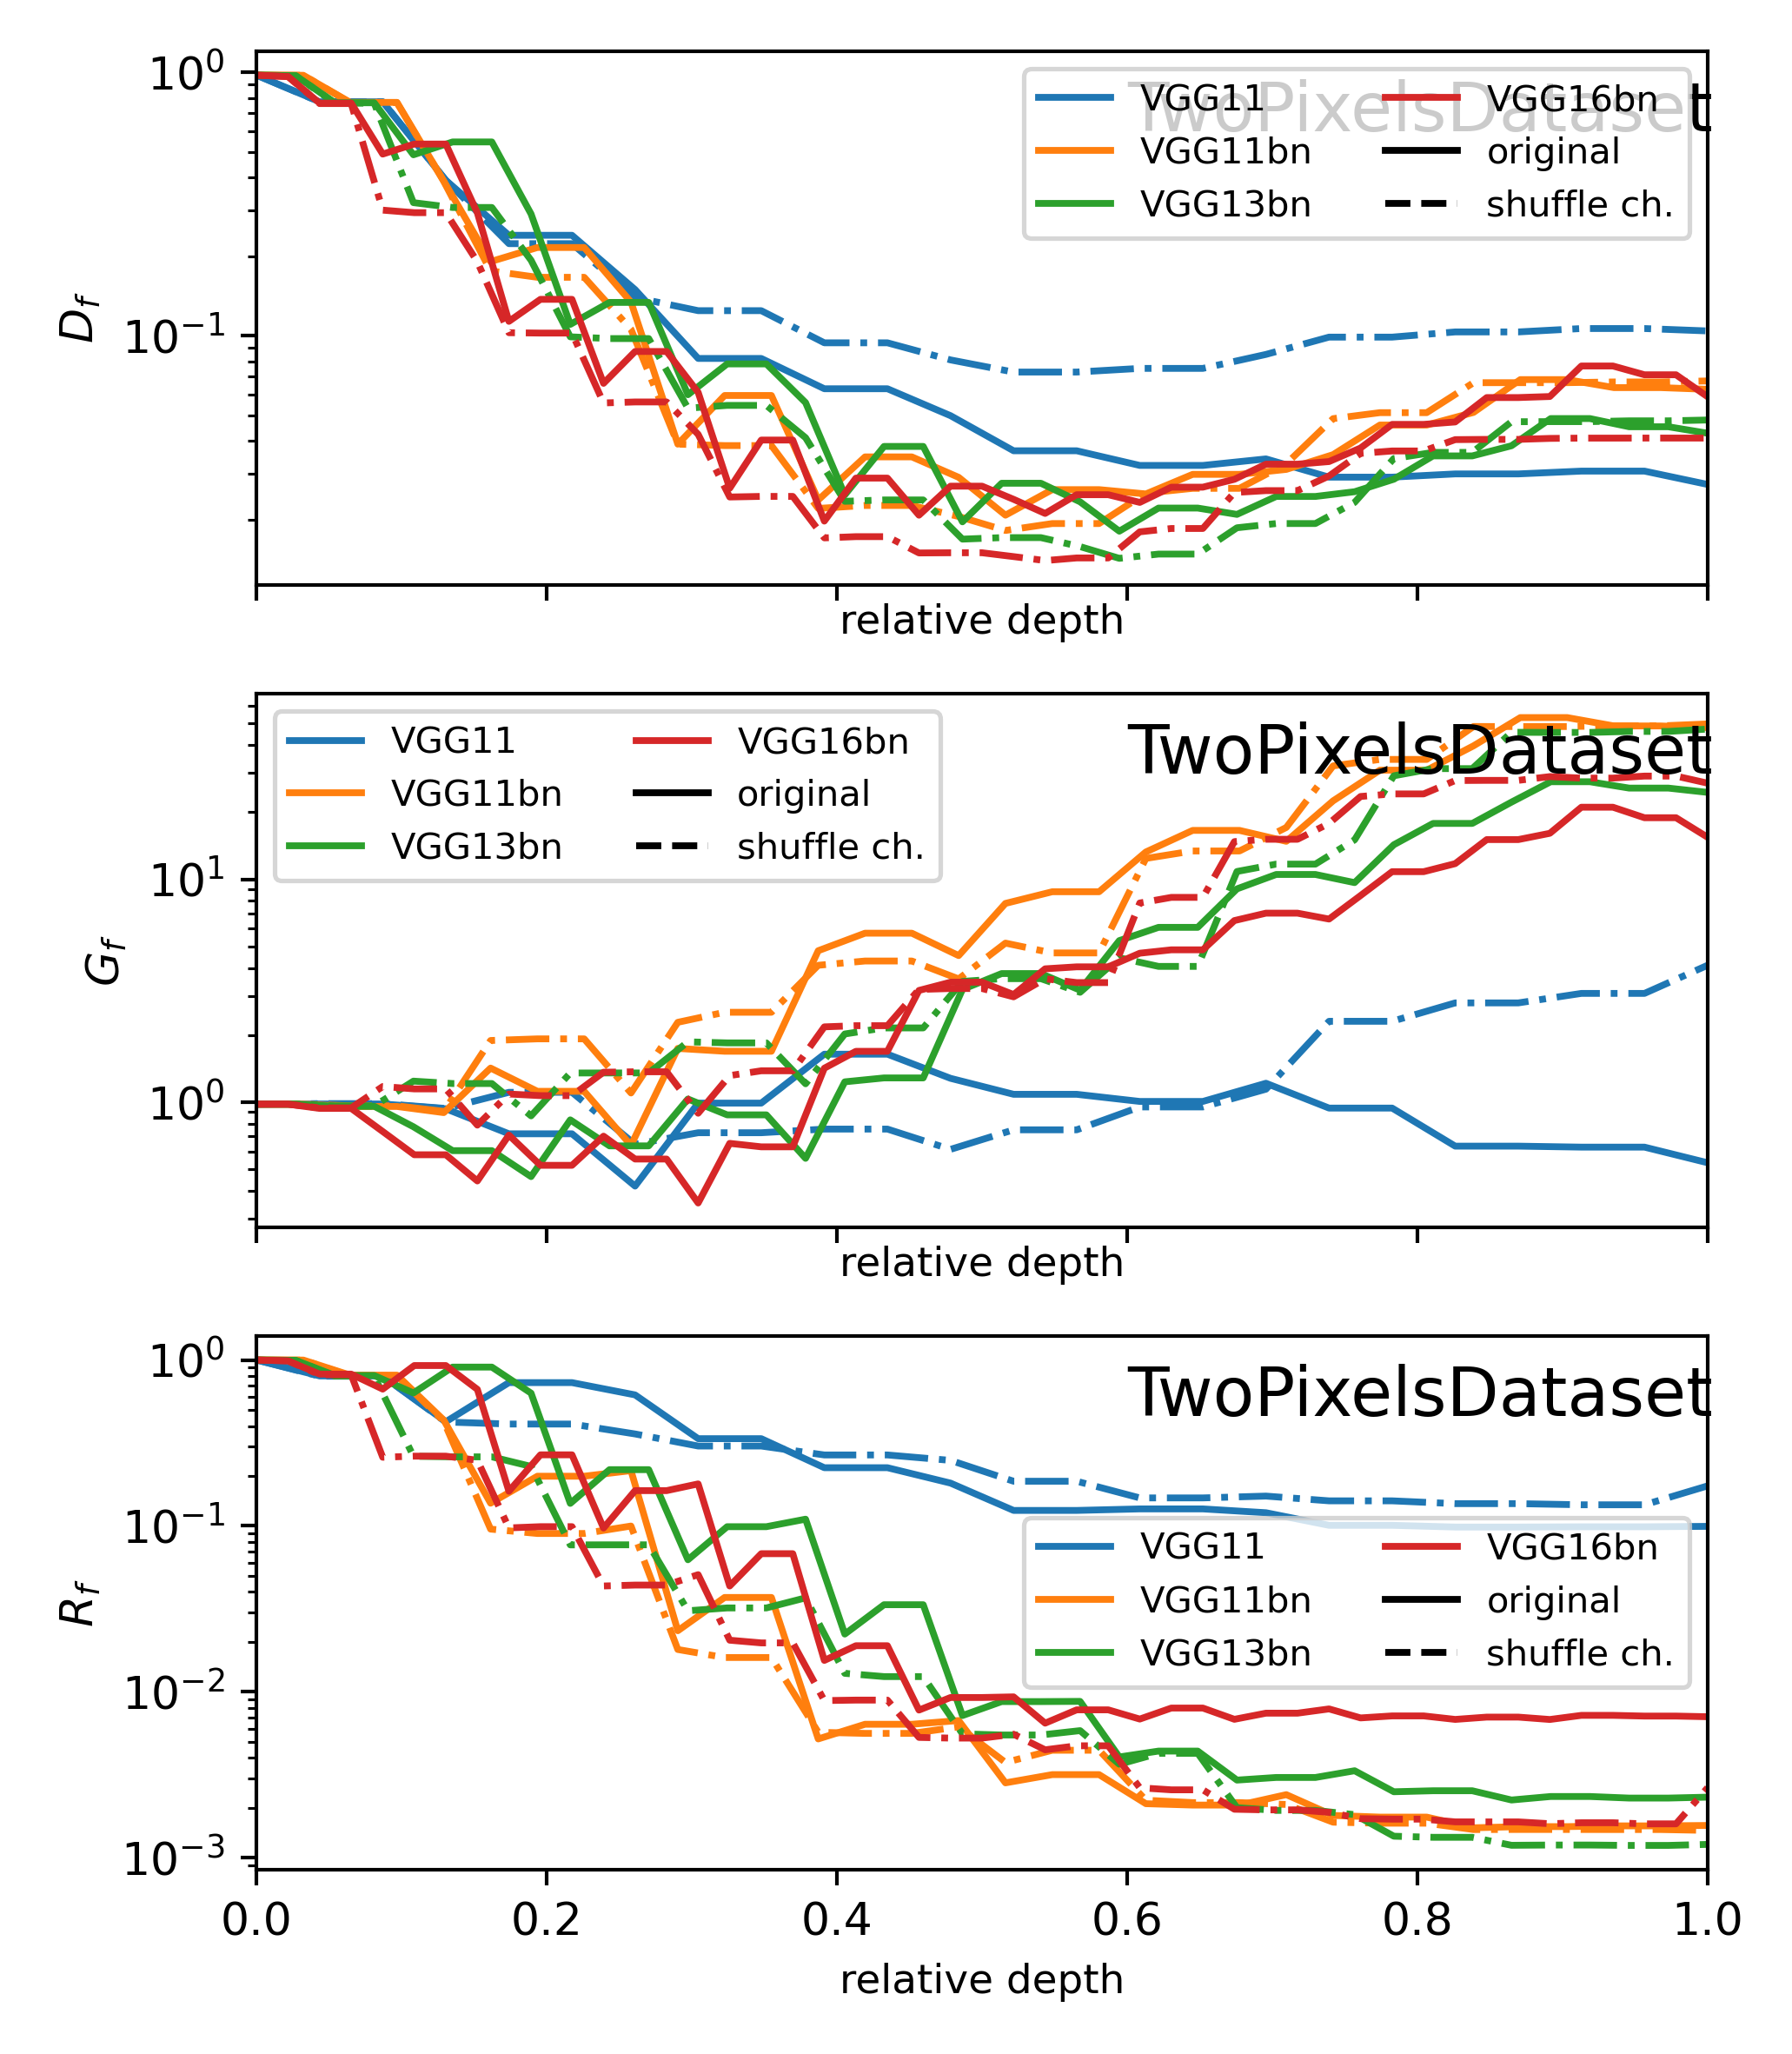

In [147]:
%matplotlib notebook

tr = 1
ptr = 1024
nets = df.net.unique()
nets.sort()

ls = ['-', '--', '-.']
yl = ['$D_f$', '$G_f$', '$R_f$']

fig, ax = plt.subplots(3, 1, figsize=(5.5, 6.3), dpi=150, sharex=True)

for Xi, X in enumerate([D, G, R]):
    
    plt.sca(ax[Xi])

    for i, net in enumerate(nets):
        for sch in [0, 2]:
            r = X[ptr][sch][net][tr].values # / R[net][0].values
            plt.plot(np.linspace(0, 1, len(r)), r, c=f'C{i}', ls=ls[sch], label=net if not sch else None)

            ks = R[ptr][sch][net][tr].keys()
#             for ii, v in enumerate(zip(np.linspace(0, 1, len(r)), r)):
#                 plt.text(*v, ks[ii][2:], fontsize=2)

    plt.ylabel(yl[Xi], fontsize=10)
    plt.yscale('log')

    plt.plot([], [], 'k', label='original')
    plt.plot([], [], '--k', label='shuffle ch.')
    #     plt.plot([], [], 'k', ls='dotted', label='ratio')
    plt.legend(fontsize=8, ncol=2)
    plt.xlim(0, 1)
#     plt.ylim(-3, 1)
    plt.xlabel('relative depth', fontsize=9)
    plt.annotate(f'TwoPixelsDataset', xy=(0.6, 0.85), xycoords='axes fraction', horizontalalignment='left', fontsize=15)
    
plt.tight_layout()

Check batch norm behavior: it does normalize activations map per channel on batch statistics

In [157]:
bn = nn.BatchNorm2d(10, track_running_stats=True)
bn.train()
x = torch.randn(5, 10, 32, 32)

In [158]:
x.pow(2).mean(dim=[0, 2, 3])

tensor([0.9873, 1.0120, 1.0040, 0.9839, 0.9690, 0.9984, 1.0289, 0.9846, 1.0074,
        1.0079])

In [159]:
with torch.no_grad():
    bn(x).pow(2).mean(dim=[0, 2, 3])

In [160]:
bn.running_var

tensor([0.9987, 1.0012, 1.0004, 0.9984, 0.9969, 0.9998, 1.0029, 0.9985, 1.0008,
        1.0007])

In [161]:
bn.reset_running_stats()

In [162]:
bn.running_var

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

load model and shuffle batch norm

In [290]:
from filtering_function import filtering_args

In [291]:
filename = '/home/lpetrini/results/twopoints22/'
predicate = lambda a: filtering_args(a) and a['net'] == 'VGG11bn' and \
                      a['seed_init'] == 0
runs = load(filename, pred_args=predicate)

In [293]:
r = runs[0]
state = r['best']['net']

In [140]:
state['module.features.2.num_batches_tracked']

tensor(192, device='cuda:0')

check that vgg_bylayer and feature extractor do the same thing

In [89]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [251]:
def vgg_bylayer(net, i=1, return_names=False):
    ls = []
    lsn = []
    for n, c in list(net.children())[0].named_children():
        ls.append(c)
        lsn.append(n)
    ls.append(nn.Flatten())
    lsn.append('fl')
    ls.append(list(net.children())[1])
    lsn.append('classifier')
    if return_names:
        return lsn
    else:
        return nn.Sequential(*ls[:(i+1)]) #, lsn[:[i+1]]

In [250]:
f = load_net_from_run(r, tr, device='cuda', shuffle_channels=0)
nodes, _ = get_graph_node_names(f)
nodes = [node for node in nodes if node not in ['x', 'size', 'view', 'squeeze']]
l = create_feature_extractor(f, return_nodes=nodes)

In [259]:
x = torch.randn(10, 1, 28, 28, device='cuda')

In [261]:
l(x)['features.5']

tensor([[[[ 8.4449e-02,  1.3400e+00, -1.2341e+00,  ..., -6.1949e-01,
           -1.5844e+00, -8.1434e-01],
          [ 1.3270e+00,  1.9534e+00,  1.9933e-01,  ...,  9.9347e-01,
           -2.6608e-02, -3.3046e-01],
          [ 1.7688e+00,  2.2738e+00,  1.6830e+00,  ...,  3.8430e+00,
            1.3799e+00, -1.0167e+00],
          ...,
          [ 1.5463e+00,  2.8273e+00,  3.2420e+00,  ...,  1.5113e+00,
            3.7119e+00, -5.5630e-01],
          [ 1.9776e+00,  2.5741e+00,  2.7738e+00,  ...,  1.8310e+00,
            3.3459e+00,  9.1076e-02],
          [ 1.2745e+00,  2.6063e+00,  2.9762e+00,  ...,  1.9097e+00,
            1.6379e+00,  8.8064e-01]],

         [[ 1.0705e+00,  1.7345e+00,  2.1587e+00,  ...,  2.8722e+00,
            1.7042e+00,  7.0992e-01],
          [ 9.9368e-01,  2.3045e+00,  2.4456e+00,  ...,  3.9266e+00,
            3.3697e+00,  1.1183e+00],
          [ 1.1596e+00,  2.8565e+00,  3.7805e+00,  ...,  4.0858e+00,
            3.7967e+00,  2.6837e+00],
          ...,
     

In [262]:
vgg_bylayer(f, 5)(x)

tensor([[[[ 8.4449e-02,  1.3400e+00, -1.2341e+00,  ..., -6.1949e-01,
           -1.5844e+00, -8.1434e-01],
          [ 1.3270e+00,  1.9534e+00,  1.9933e-01,  ...,  9.9347e-01,
           -2.6608e-02, -3.3046e-01],
          [ 1.7688e+00,  2.2738e+00,  1.6830e+00,  ...,  3.8430e+00,
            1.3799e+00, -1.0167e+00],
          ...,
          [ 1.5463e+00,  2.8273e+00,  3.2420e+00,  ...,  1.5113e+00,
            3.7119e+00, -5.5630e-01],
          [ 1.9776e+00,  2.5741e+00,  2.7738e+00,  ...,  1.8310e+00,
            3.3459e+00,  9.1076e-02],
          [ 1.2745e+00,  2.6063e+00,  2.9762e+00,  ...,  1.9097e+00,
            1.6379e+00,  8.8064e-01]],

         [[ 1.0705e+00,  1.7345e+00,  2.1587e+00,  ...,  2.8722e+00,
            1.7042e+00,  7.0992e-01],
          [ 9.9368e-01,  2.3045e+00,  2.4456e+00,  ...,  3.9266e+00,
            3.3697e+00,  1.1183e+00],
          [ 1.1596e+00,  2.8565e+00,  3.7805e+00,  ...,  4.0858e+00,
            3.7967e+00,  2.6837e+00],
          ...,
     

In [271]:
'filename = 'twopoints_'
add = 'bkgnoise_stab' 
# add = '_convgap22_2stab'
runs = load(prefix + filename + add, pred_args=lambda a: a['P'] >= 500 and a['gap'] == 2)
# 
df = pd.DataFrame()

for r in runs:
    df = pd.concat([df,
        r['df']
    ], )

SyntaxError: unterminated string literal (detected at line 1) (2525860406.py, line 1)

In [272]:
df['ptr'] = df.run_args.apply(lambda a: a.ptr)
# df['sch'] = df.args.apply(lambda a: a.shuffle_channels)
df['noise'] = df.run_args.apply(lambda a: a.background_noise)

In [277]:
df

args                                           run_args    dataset    net  \
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
..   ...                                                ...        ...    ...   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   
0    NaN  Namespace(device='cuda', dtype='float64', seed...  twopoints  VGG11   

              layer  li  trained        acc  epoch         D         G  \
0    000 features.0   0        0  99.780273     48  0.977484  0.977484   
0    001 features.1   1        0  99.780273     48  0.775413  1.003670   
0    002 features.2   2        0  99.780273     48  0.775413  1.003670   
0    003 features.3   3        0  99.780273     48  0.394969  0.932326   
0    004 features.4   4        0  99.780273     48  0.367698  0.939764   
..              ...  ..      ...        ...    ...       ...       ...   
0   019 features.19  19        1  99.804688     16  0.042823  0.142420   
0   020 features.20  20        1  99.804688     16  0.042823  0.142420   
0   021 features.21  21        1  99.804688     16  0.046909  0.159350   
0   022 features.22  22        1  99.804688     16  0.046909  0.159350   
0    023 classifier  23        1  99.804688     16  0.047203  0.162981   

            deno   ptr  noise         R  
0    1564.857133  1024   0.01  1.000000  
0   15984.035137  1024   0.01  0.772578  
0   15984.035137  1024   0.01  0.772578  
0   12587.030381  1024   0.01  0.423638  
0    3721.278373  1024   0.01  0.391267  
..           ...   ...    ...       ...  
0      35.310898  1024   0.01  0.300679  
0      35.310898  1024   0.01  0.300679  
0      27.665821  1024   0.01  0.294375  
0      27.665821  1024   0.01  0.294375  
0      37.737576  1024   0.01  0.289622  

[9688 rows x 15 columns]

In [273]:
# df['bias'] = df.run_args.apply(lambda a: 1 if 'bias' not in a.__dict__ else a.bias)

# df = df[df['bias'] == 0]

In [274]:
vggfil = (df.net == 'VGG11') | (df.net == 'VGG11bn') | (df.net == 'VGG16bn')
df[vggfil]['li'] = df[vggfil].layer.apply(lambda a: int(a.split('.')[1]) if '.' in a else a)
df[vggfil]['layer'] = df[vggfil].apply(lambda row: vgg_layer_names(row.net, row.li) if row.li != 'classifier' else 'classifier', axis=1)

/tmp/ipykernel_20352/442188008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[vggfil]['li'] = df[vggfil].layer.apply(lambda a: int(a.split('.')[1]) if '.' in a else a)
/tmp/ipykernel_20352/442188008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[vggfil]['layer'] = df[vggfil].apply(lambda row: vgg_layer_names(row.net, row.li) if row.li != 'classifier' else 'classifier', axis=1)


In [275]:
df['layer'] = df.apply(lambda row: str(row.li).zfill(3) + ' ' + row.layer, axis=1)

In [276]:
df['R'] = df['D'] / df['G']
df['G'] = df['G'] / df['deno']
df['D'] = df['D'] / df['deno']
groups = ['ptr', 'shuffle_channels', 'net', 'noise', 'layer']

R = df.groupby(groups)['R'].apply(np.mean)
D = df.groupby(groups)['D'].apply(np.mean)
G = df.groupby(groups)['G'].apply(np.mean)

KeyError: 'shuffle_channels'

In [257]:
df.noise.unique()

array([ 0.01, 10.  ,  1.  ,  0.1 ])

<IPython.core.display.Javascript object>


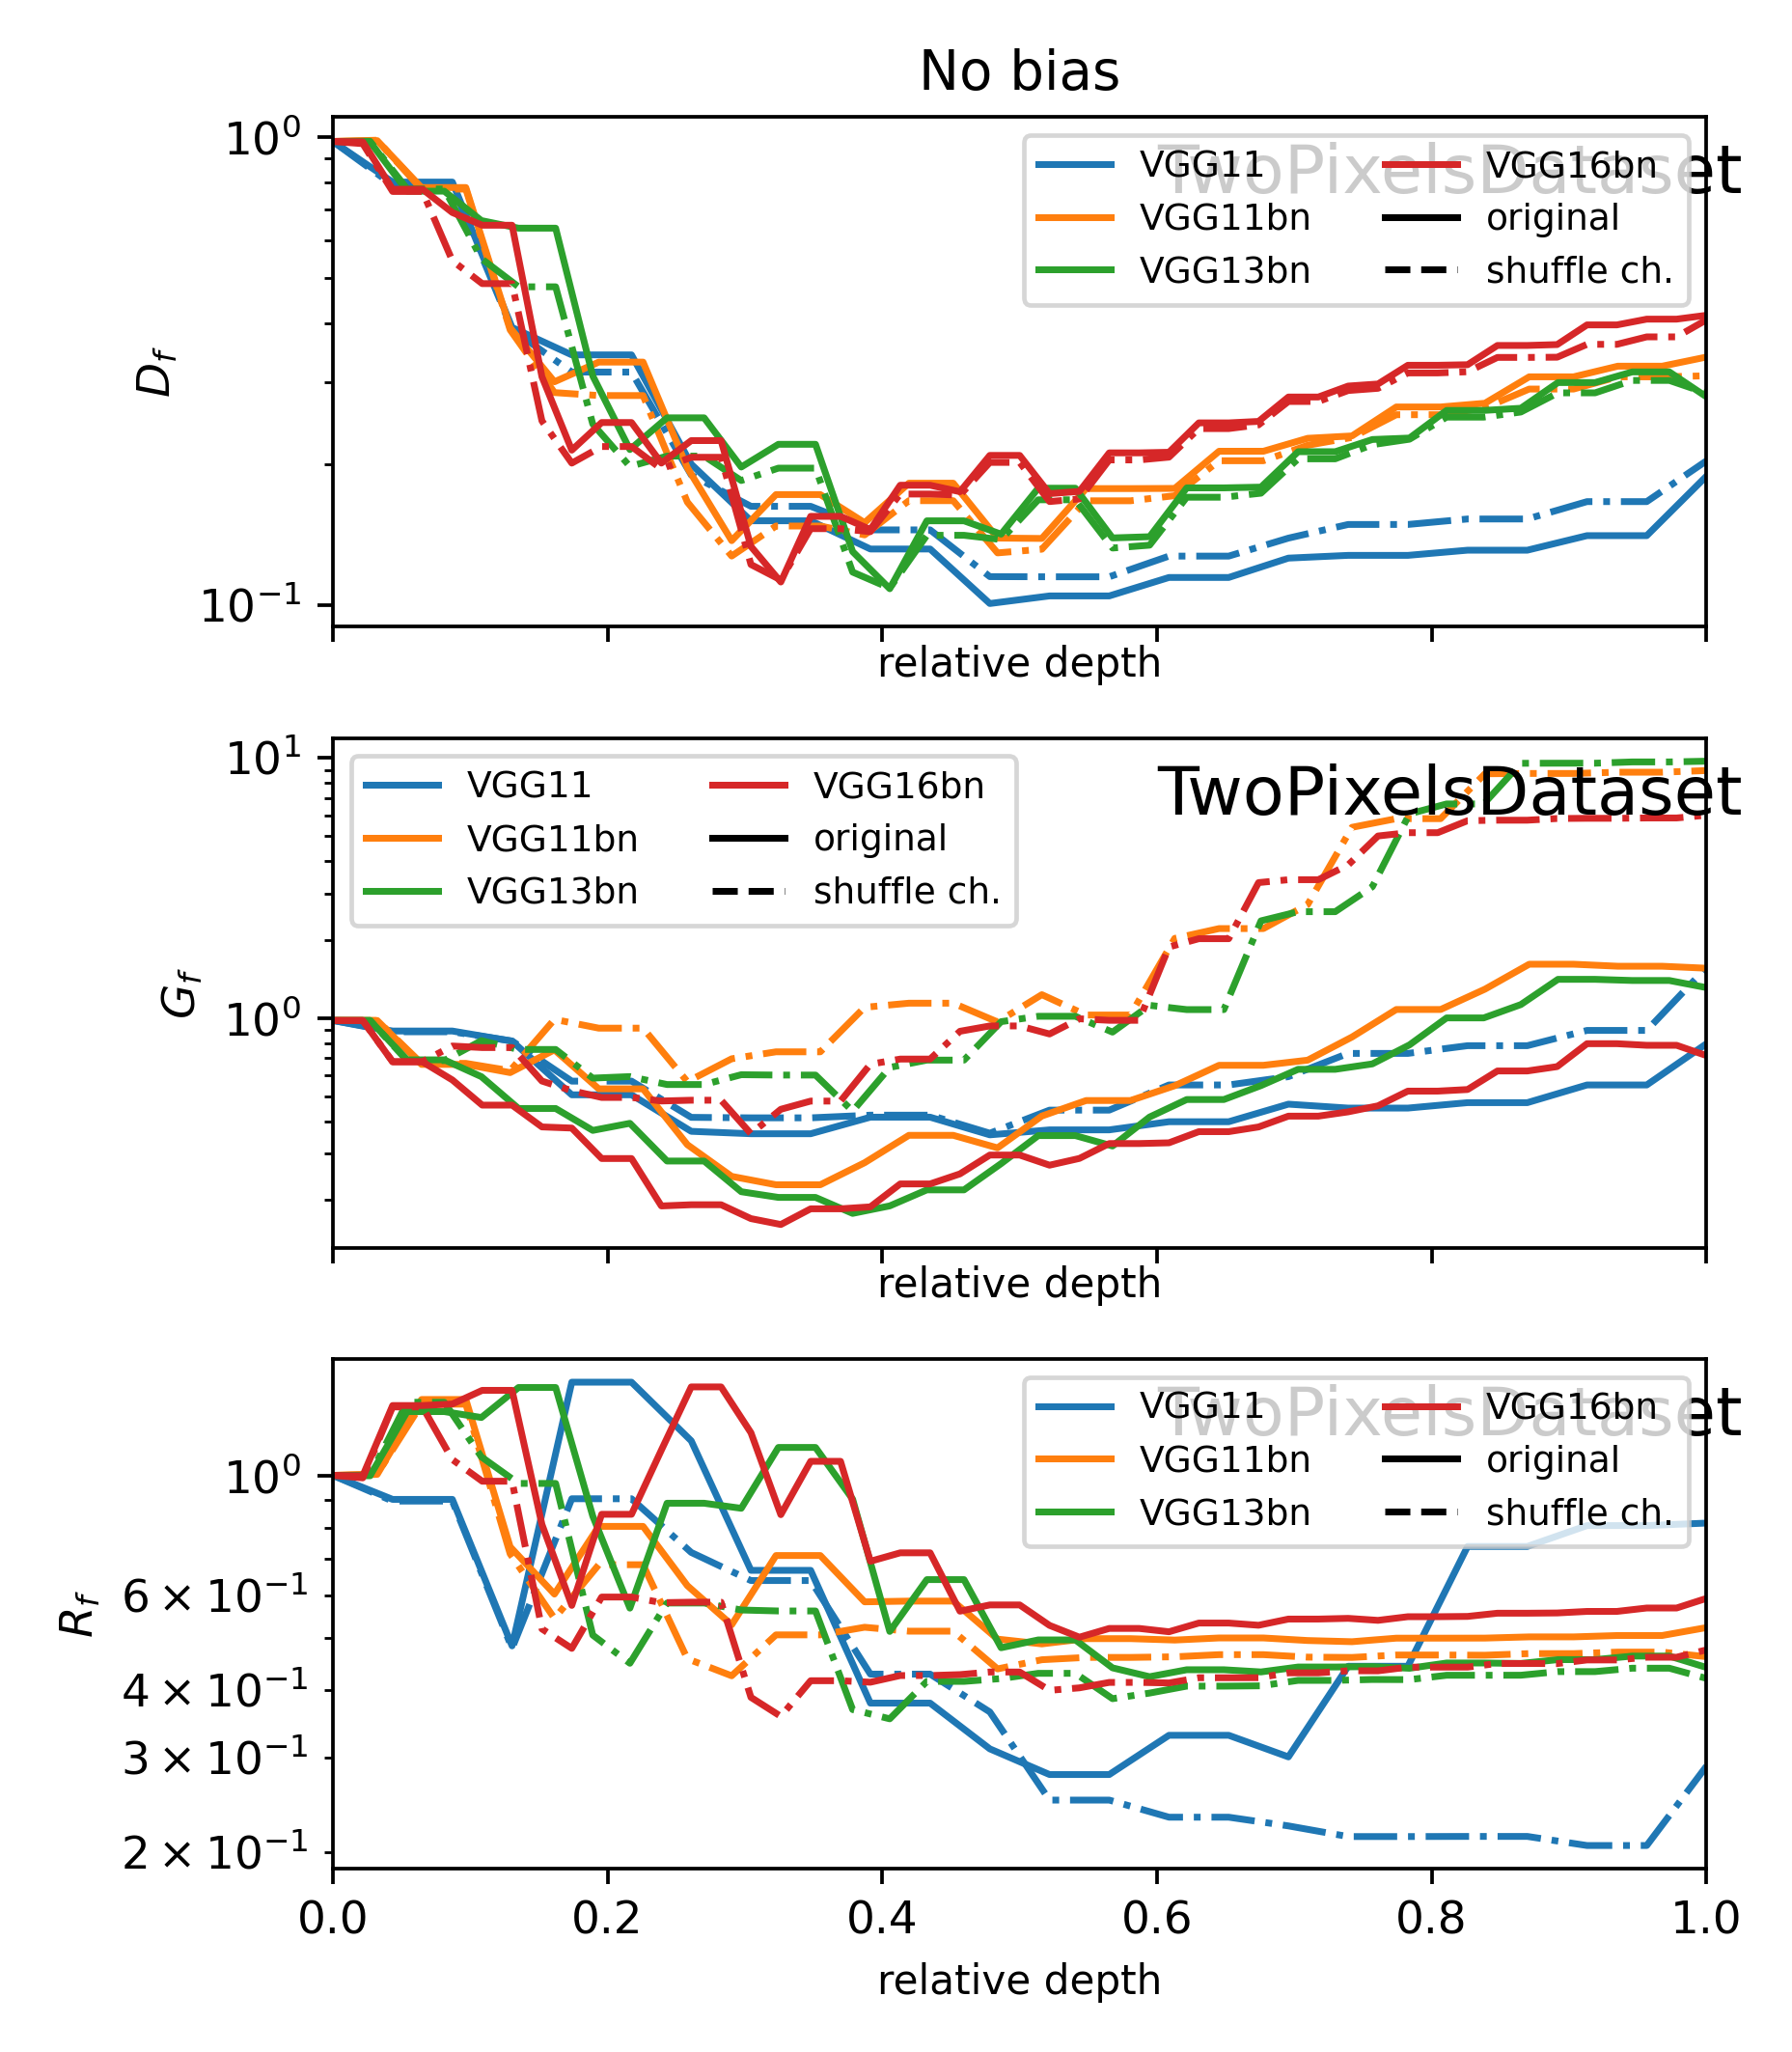

In [260]:
%matplotlib notebook

tr = 1
ptr = 1024
nets = df.net.unique()
nets.sort()

ls = ['-', '--', '-.']
yl = ['$D_f$', '$G_f$', '$R_f$']

fig, ax = plt.subplots(3, 1, figsize=(5.5, 6.3), dpi=150, sharex=True)

for Xi, X in enumerate([D, G, R]):
    
    plt.sca(ax[Xi])

    for i, net in enumerate(nets):
        for sch in [0, 2]:
            r = X[ptr][sch][net][tr].values # / R[net][0].values
            plt.plot(np.linspace(0, 1, len(r)), r, c=f'C{i}', ls=ls[sch], label=net if not sch else None)

            ks = R[ptr][sch][net][tr].keys()
#             for ii, v in enumerate(zip(np.linspace(0, 1, len(r)), r)):
#                 plt.text(*v, ks[ii][2:], fontsize=2)

    plt.ylabel(yl[Xi], fontsize=10)
    plt.yscale('log')

    plt.plot([], [], 'k', label='original')
    plt.plot([], [], '--k', label='shuffle ch.')
    #     plt.plot([], [], 'k', ls='dotted', label='ratio')
    plt.legend(fontsize=8, ncol=2)
    plt.xlim(0, 1)
#     plt.ylim(-3, 1)
    plt.xlabel('relative depth', fontsize=9)
    plt.annotate(f'TwoPixelsDataset', xy=(0.6, 0.85), xycoords='axes fraction', horizontalalignment='left', fontsize=15)
    if Xi == 0:
        plt.title('No bias')
plt.tight_layout()

In [261]:
runs = load(prefix + filename + '22_stab4', pred_args=lambda a: a['P'] >= 500 and a['gap'] == 2)
# _convgap22_2stab
df = pd.DataFrame()

for r in runs:
    df = pd.concat([df,
        r['df']
    ], )

# # df = df[(df.net == 'VGG11') | (df.net == 'VGG11bn') | (df.net == 'VGG13bn') | (df.net == 'VGG16bn')]
df = df[df.net != 'ResNet34']
df = df[df.acc > 70]

df['ptr'] = df.run_args.apply(lambda a: a.ptr)
df['sch'] = df.args.apply(lambda a: a.shuffle_channels)

df['bias'] = df.run_args.apply(lambda a: 1 if 'bias' not in a.__dict__ else a.bias)

df = df[df['bias'] == 0]

vggfil = (df.net == 'VGG11') | (df.net == 'VGG11bn') | (df.net == 'VGG16bn')
df[vggfil]['li'] = df[vggfil].layer.apply(lambda a: int(a.split('.')[1]) if '.' in a else a)
df[vggfil]['layer'] = df[vggfil].apply(lambda row: vgg_layer_names(row.net, row.li) if row.li != 'classifier' else 'classifier', axis=1)

df['layer'] = df.apply(lambda row: str(row.li).zfill(3) + ' ' + row.layer, axis=1)

df['R'] = df['D'] / df['G']
groups = ['ptr', 'sch', 'net', 'trained', 'layer']

R = df.groupby(groups)['R'].apply(np.mean)
D = df.groupby(groups)['D'].apply(np.mean)
G = df.groupby(groups)['G'].apply(np.mean)

%matplotlib notebook

tr = 1
ptr = 1024
nets = df.net.unique()
nets.sort()

ls = ['-', '--', '-.']
yl = ['$D_f$', '$G_f$', '$R_f$']

fig, ax = plt.subplots(3, 1, figsize=(5.5, 6.3), dpi=150, sharex=True)

for Xi, X in enumerate([D, G, R]):
    
    plt.sca(ax[Xi])

    for i, net in enumerate(nets):
        for sch in [0, 2]:
            r = X[ptr][sch][net][tr].values # / R[net][0].values
            plt.plot(np.linspace(0, 1, len(r)), r, c=f'C{i}', ls=ls[sch], label=net if not sch else None)

            ks = R[ptr][sch][net][tr].keys()
#             for ii, v in enumerate(zip(np.linspace(0, 1, len(r)), r)):
#                 plt.text(*v, ks[ii][2:], fontsize=2)

    plt.ylabel(yl[Xi], fontsize=10)
    plt.yscale('log')

    plt.plot([], [], 'k', label='original')
    plt.plot([], [], '--k', label='shuffle ch.')
    #     plt.plot([], [], 'k', ls='dotted', label='ratio')
    plt.legend(fontsize=8, ncol=2)
    plt.xlim(0, 1)
#     plt.ylim(-3, 1)
    plt.xlabel('relative depth', fontsize=9)
    plt.annotate(f'TwoPixelsDataset', xy=(0.6, 0.85), xycoords='axes fraction', horizontalalignment='left', fontsize=15)
    if Xi == 0:
        plt.title('No bias')
plt.tight_layout()

NotADirectoryError: /home/lpetrini/results/twopoints_22_stab4 does not exists

check weights means

In [3]:
def filtering_args(a):
    if 'bias' in a:
        f1 = a['bias'] == 1
    else:
        f1 = True
        
    return f1 and a['ptr'] == 1024 and a['gap'] == 2

In [68]:
filename = '/home/lpetrini/results/twopoints22/'
predicate = lambda a: filtering_args(a) and a['net'] == 'VGG11' and \
                      a['seed_init'] == 0
runs = load(filename, pred_args=predicate)
r = runs[0]

In [69]:
state = r['best']['net']
args = r['args']

Also do the biases

In [70]:
histm = []
histn = []
histb = []

for k in state:
    if len(state[k].shape) == 4:
        means = state[k].mean(dim=[-1, -2]).flatten()
        histm.append((torch.linspace(means.min(), means.max(), 250), torch.histc(means, bins=250).cpu()))
        norms = state[k].pow(2).sum(dim=[-1, -2]).sqrt().flatten()
        histn.append((torch.linspace(norms.min(), norms.max(), 250), torch.histc(norms, bins=250).cpu()))

    if 'bias' in k and 'feature' in k:
        bias = state[k]
        histb.append((torch.linspace(bias.min(), bias.max(), 100), torch.histc(bias, bins=100).cpu()))

<IPython.core.display.Javascript object>


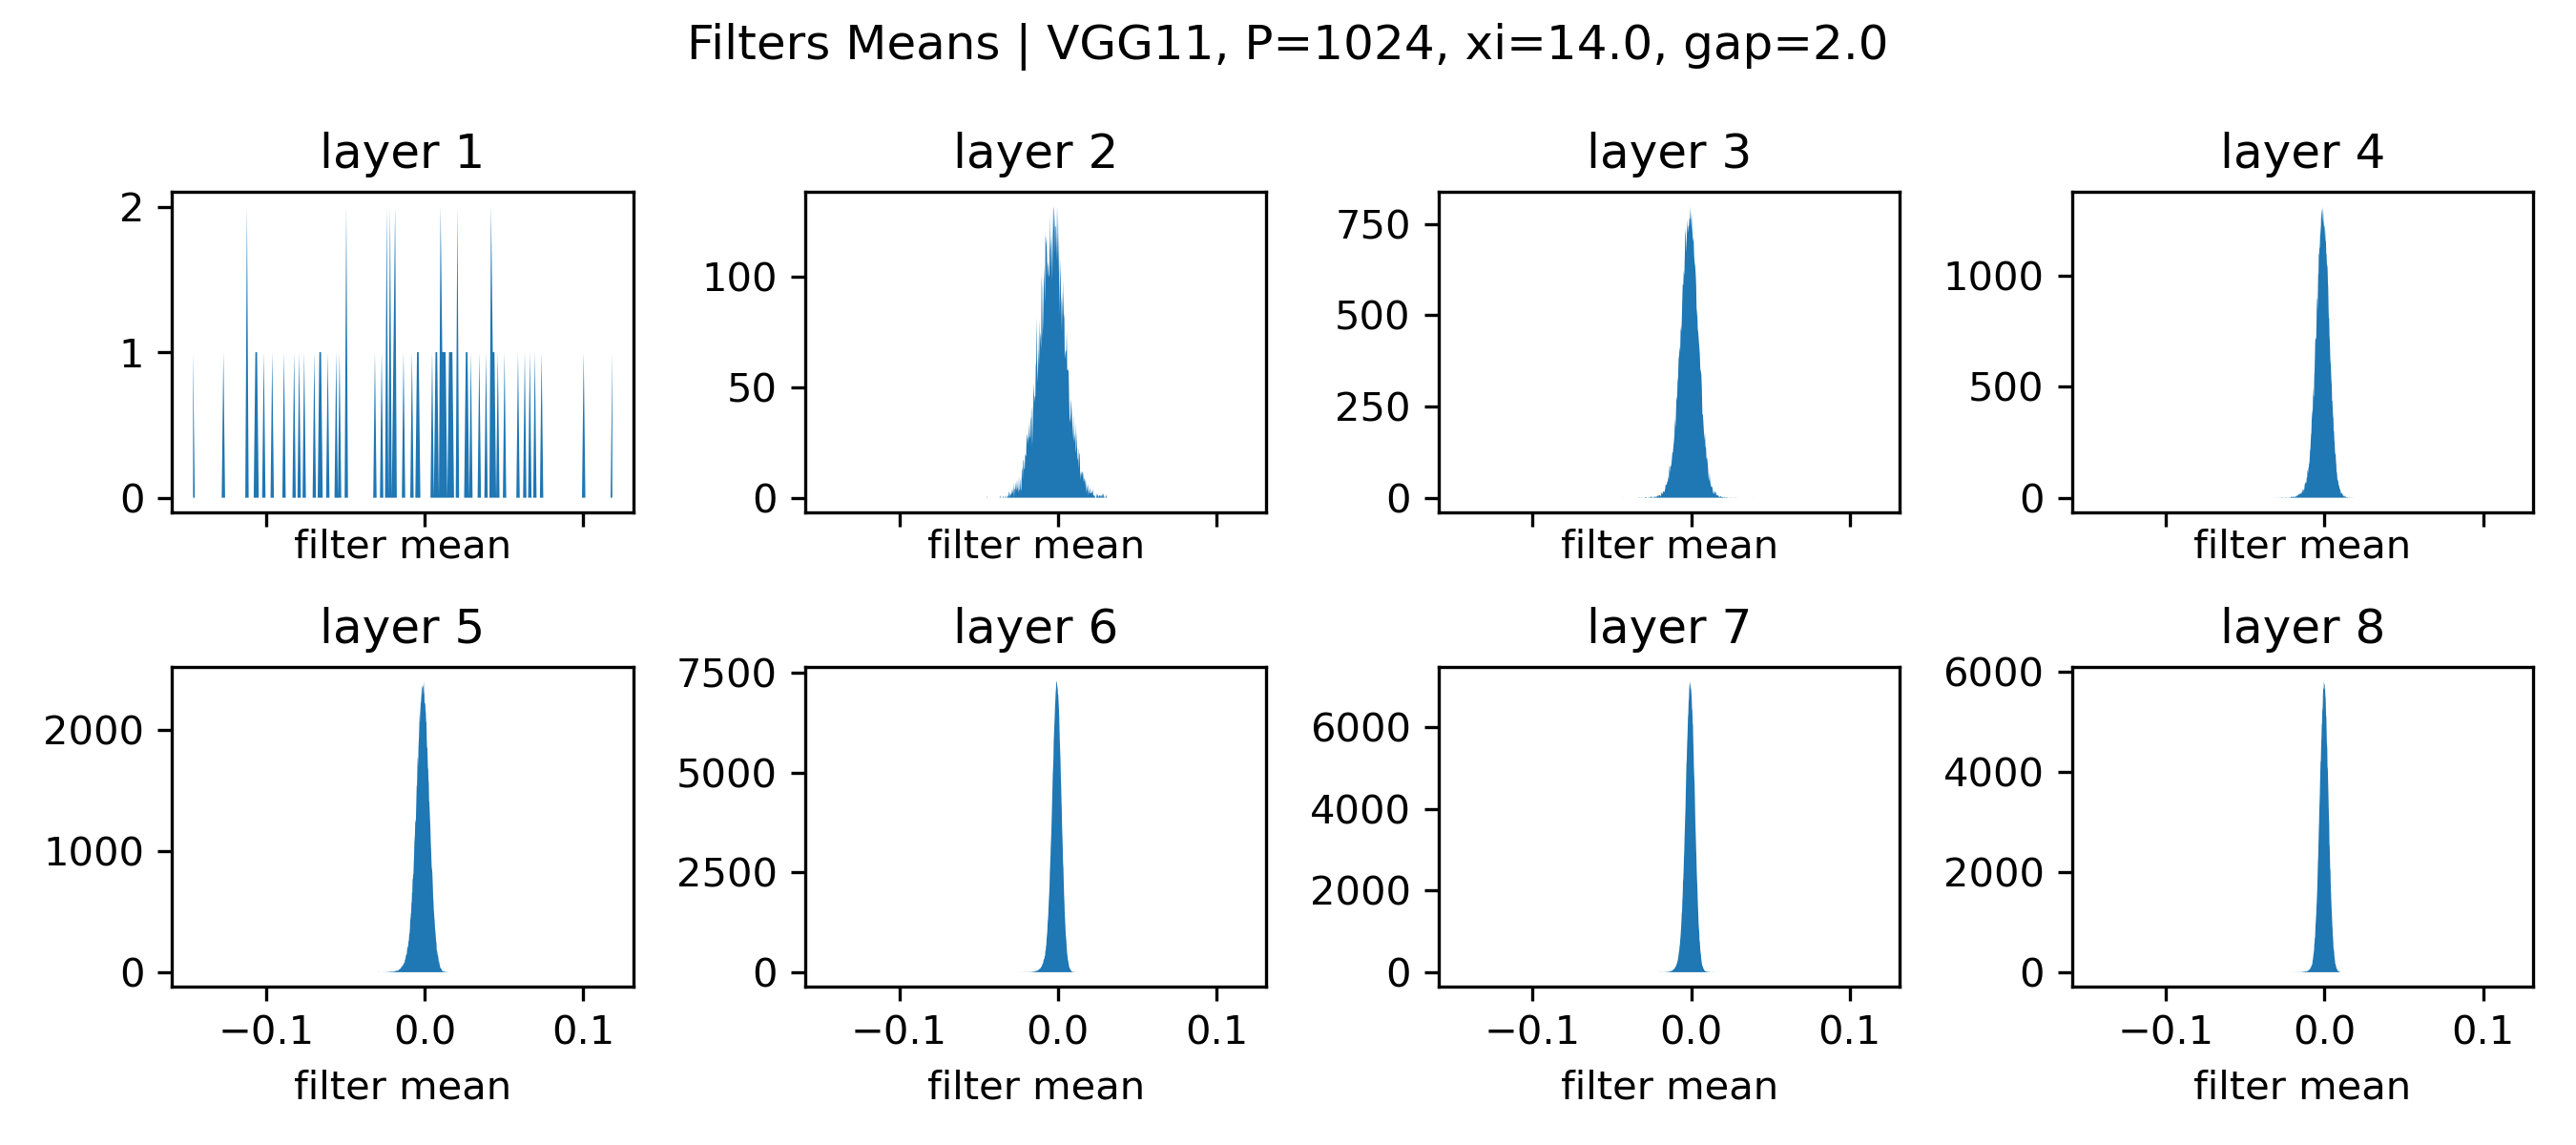

In [74]:
%matplotlib notebook
_, ax = plt.subplots(2, 4, figsize=(9, 4), dpi=120, sharex=True)
ax = [a for aa in ax for a in aa]
for i, a in enumerate(ax):
    plt.sca(a)
    plt.fill_between(*histm[i])
    plt.title(f'layer {i+1}')
    plt.xlabel('filter mean')
plt.suptitle(f'Filters Means | {args.net}, P={args.ptr}, xi={args.xi}, gap={args.gap}')
plt.tight_layout()

<IPython.core.display.Javascript object>


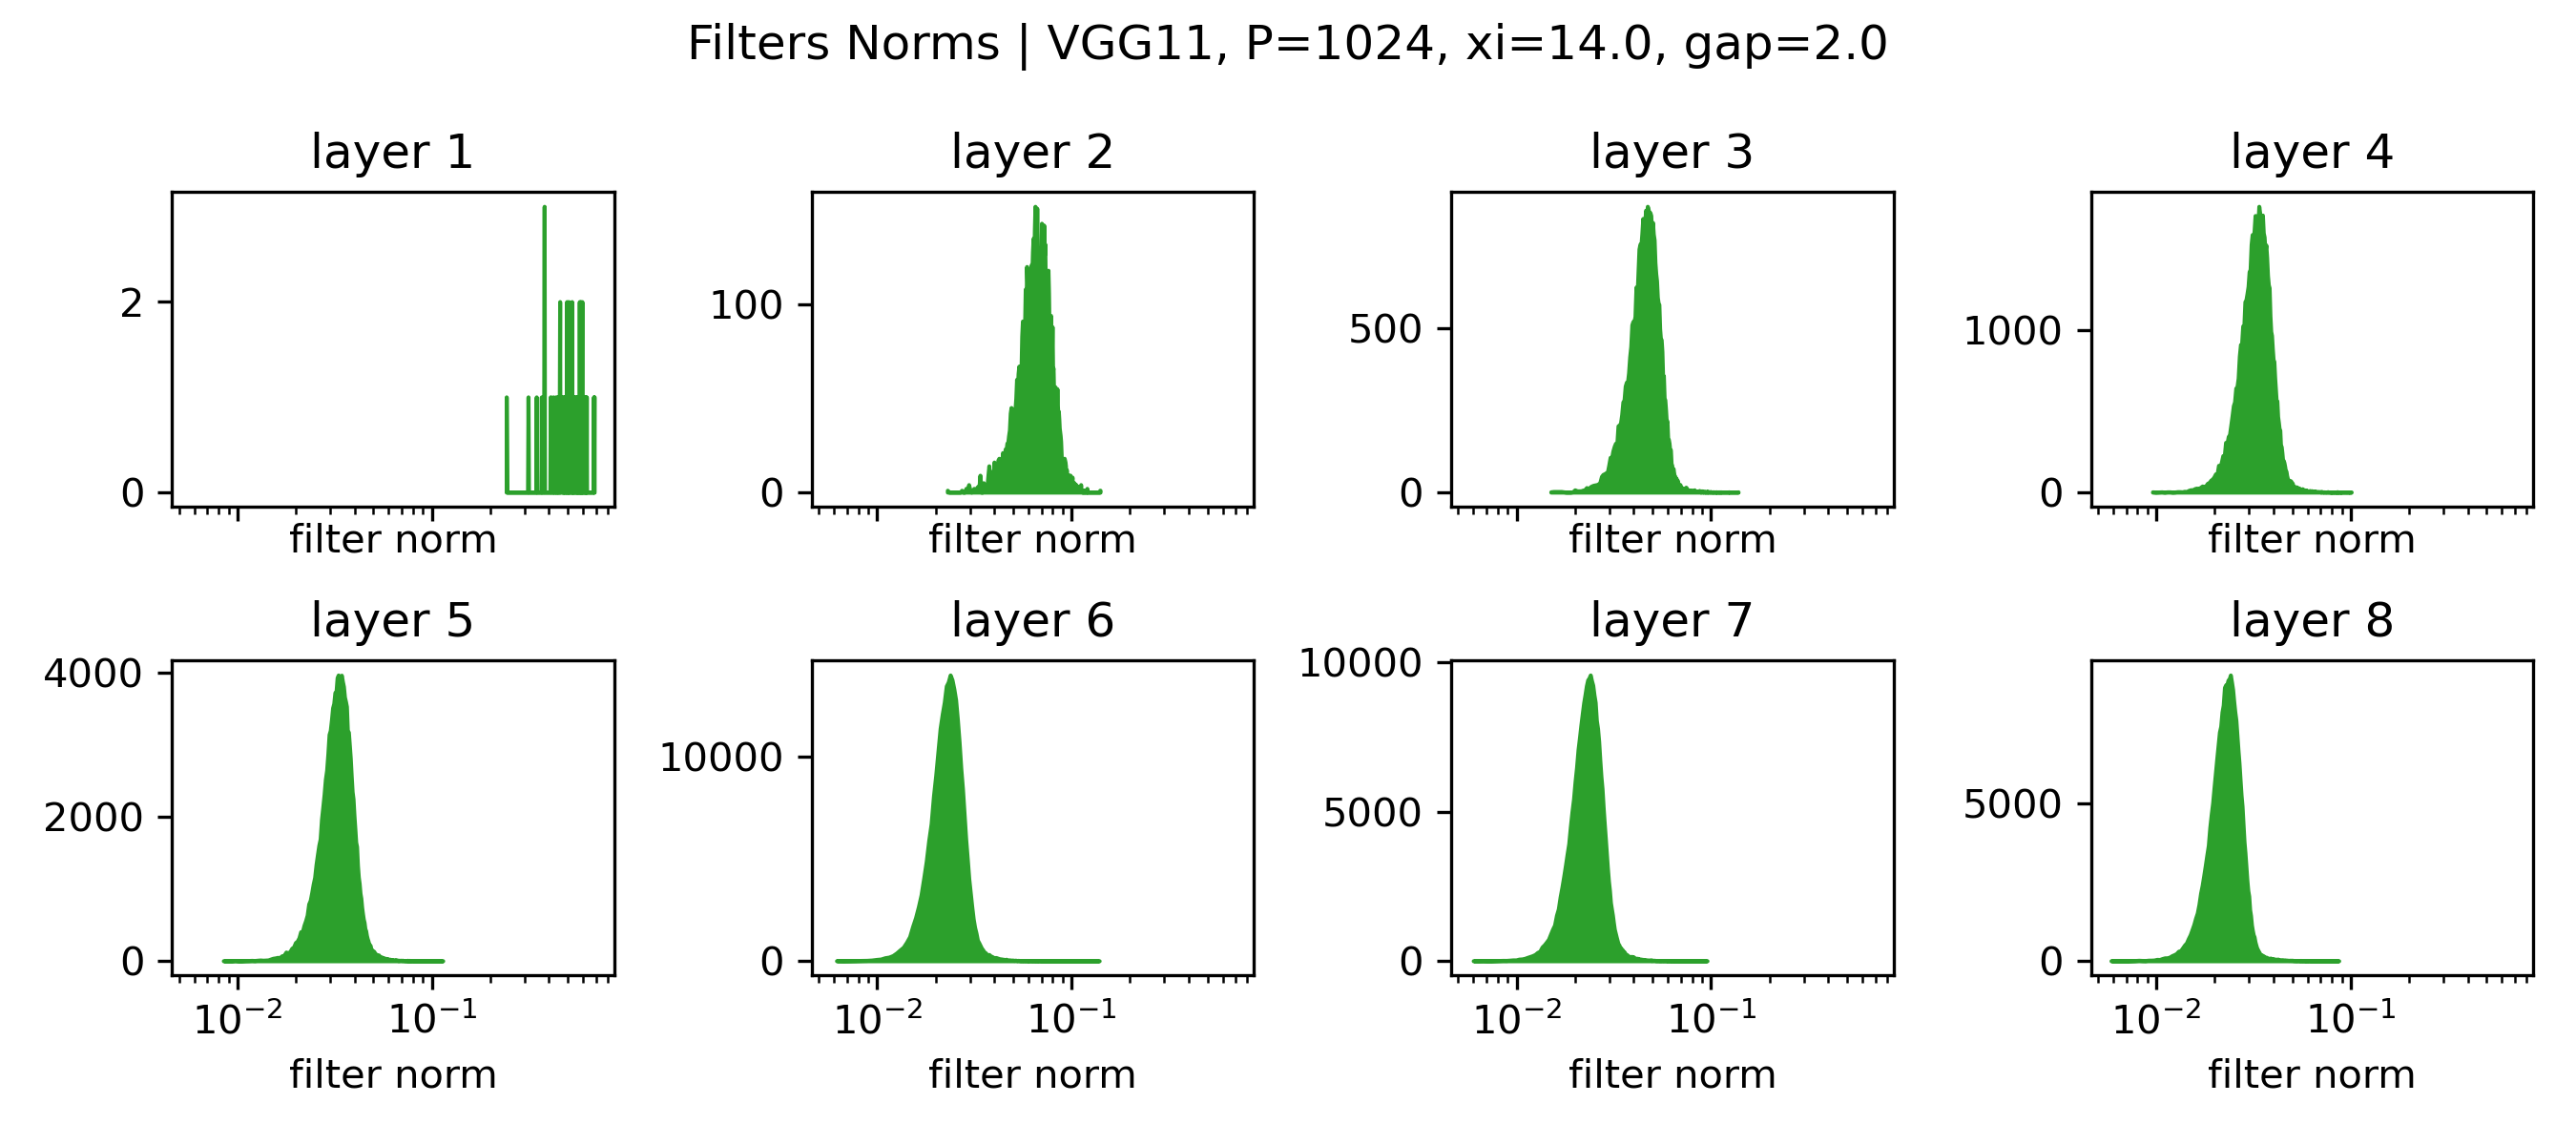

In [72]:
%matplotlib notebook
_, ax = plt.subplots(2, 4, figsize=(9, 4), dpi=120, sharex=True)
ax = [a for aa in ax for a in aa]
for i, a in enumerate(ax):
    plt.sca(a)
    plt.fill_between(*histn[i], color='C2')
    plt.title(f'layer {i+1}')
    plt.xlabel('filter norm')
plt.xscale('log')
plt.suptitle(f'Filters Norms | {args.net}, P={args.ptr}, xi={args.xi}, gap={args.gap}')
plt.tight_layout()

<IPython.core.display.Javascript object>


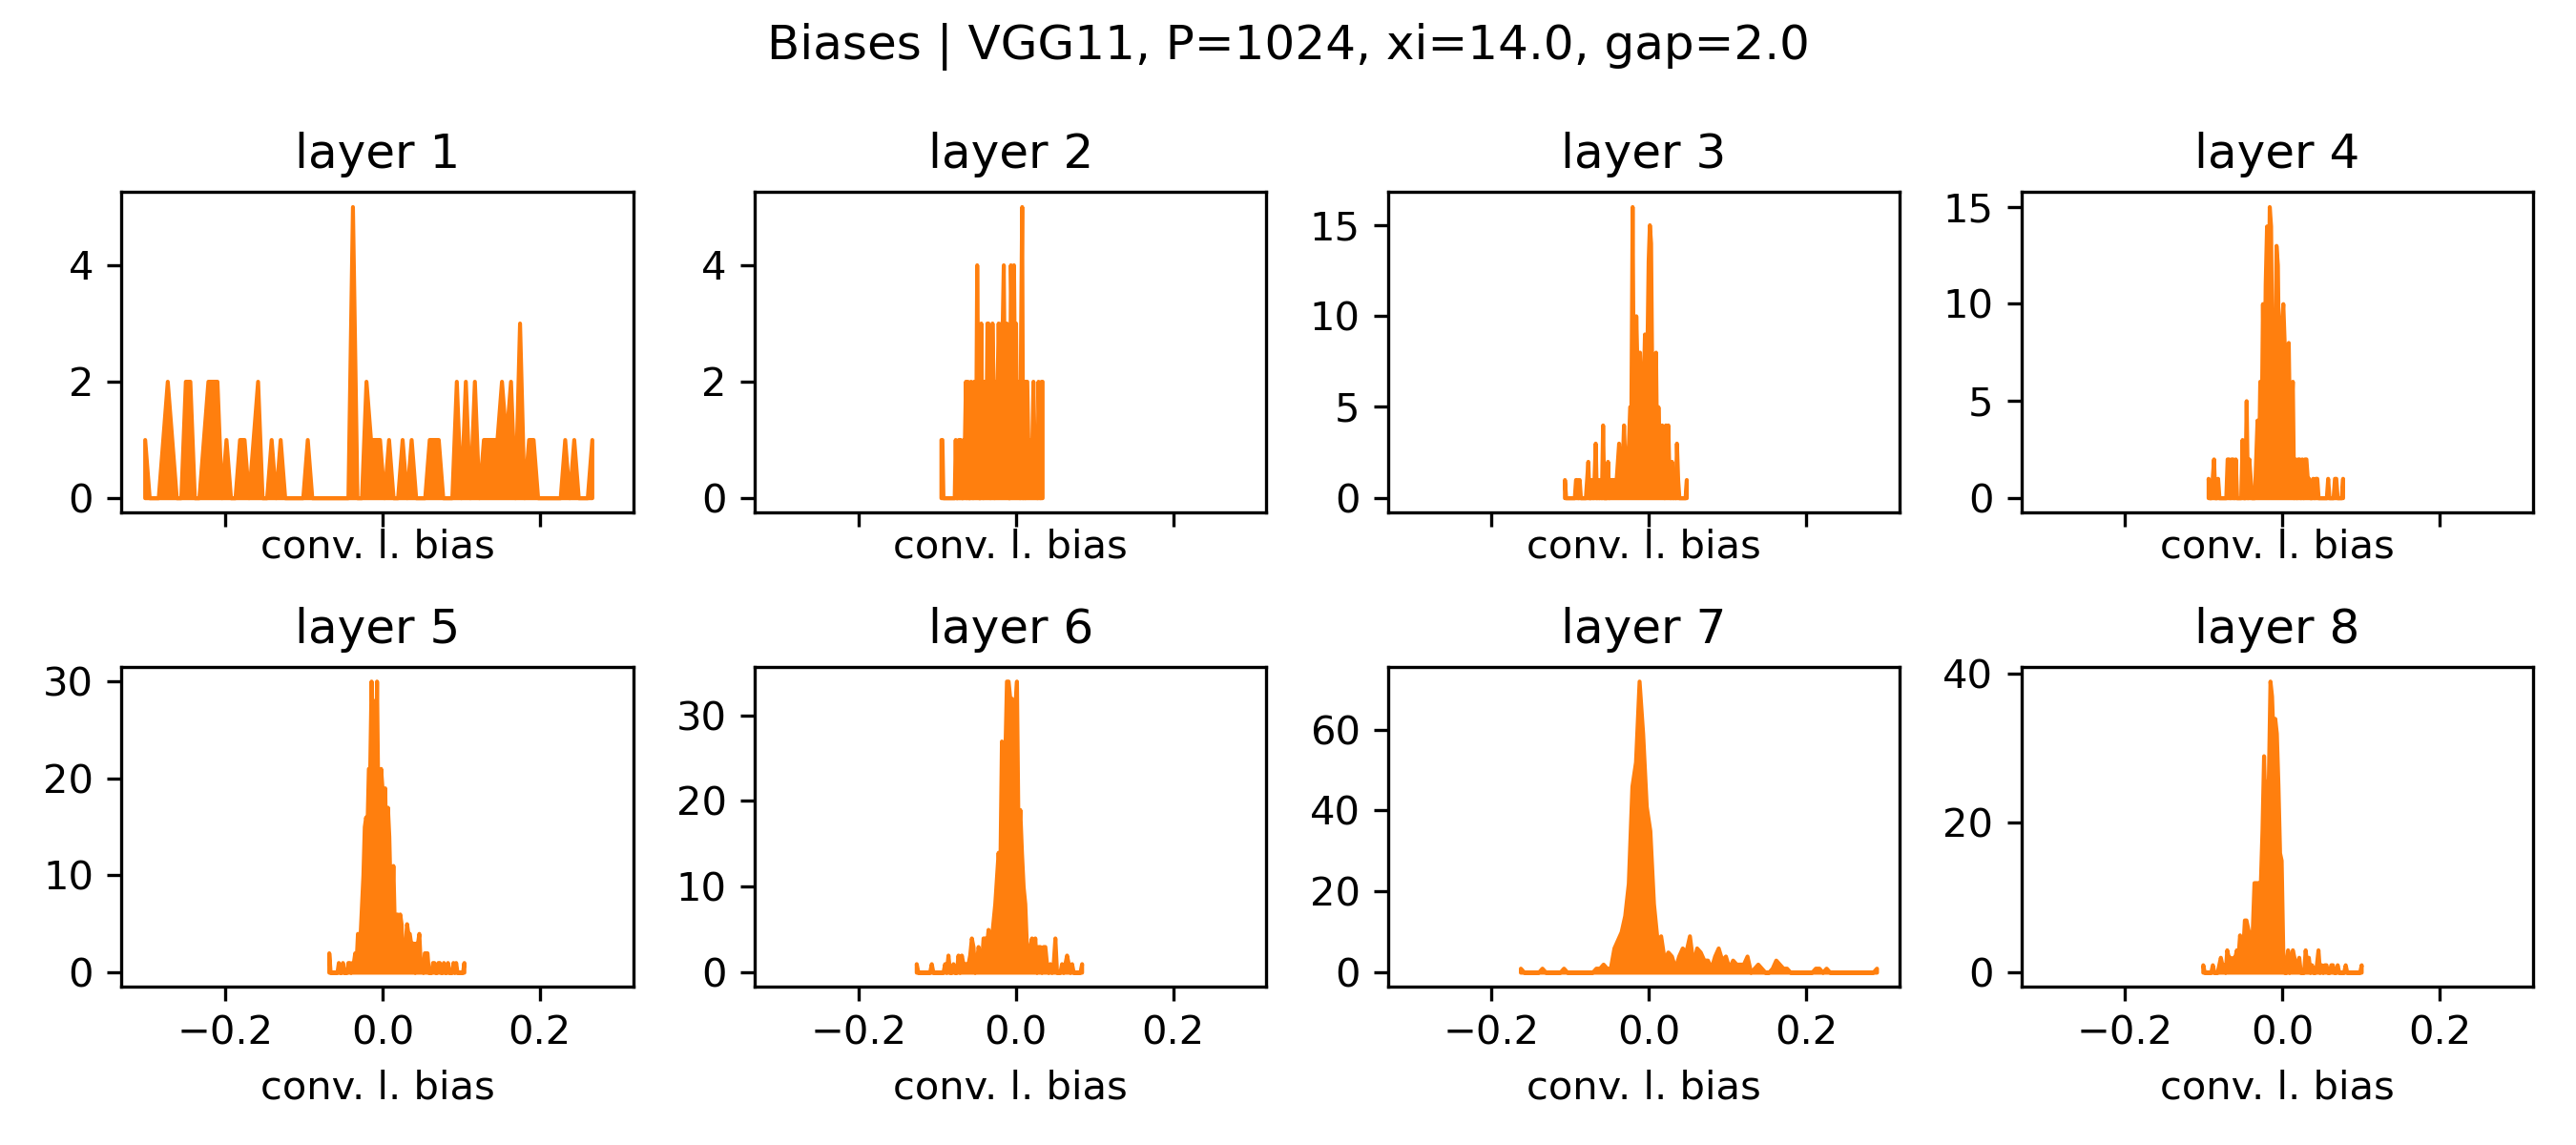

In [73]:
%matplotlib notebook
_, ax = plt.subplots(2, 4, figsize=(9, 4), dpi=120, sharex=True)
ax = [a for aa in ax for a in aa]
for i, a in enumerate(ax):
    plt.sca(a)
    plt.fill_between(*histb[i], color='C1')
    plt.title(f'layer {i+1}')
    plt.xlabel('conv. l. bias')
plt.suptitle(f'Biases | {args.net}, P={args.ptr}, xi={args.xi}, gap={args.gap}')
plt.tight_layout()

In [184]:
from models import ConvNetGAPMF

In [187]:
f = ConvNetGAPMF(n_blocks=5, input_ch=1, h=100, filter_size=3, stride=1, out_dim=2)

In [188]:
nodes, _ = get_graph_node_names(f)

In [189]:
nodes

['x',
 'conv.0.conv_0_w',
 'conv.0.size',
 'conv.0.sub',
 'conv.0.floordiv',
 'conv.0._pad',
 'conv.0.getitem',
 'conv.0.numel',
 'conv.0.pow',
 'conv.0.truediv',
 'conv.0.conv_0_b',
 'conv.0.pow_1',
 'conv.0.truediv_1',
 'conv.0.conv2d',
 'conv.0.relu',
 'conv.1.conv_1_w',
 'conv.1.size',
 'conv.1.sub',
 'conv.1.floordiv',
 'conv.1._pad',
 'conv.1.getitem',
 'conv.1.numel',
 'conv.1.pow',
 'conv.1.truediv',
 'conv.1.conv_1_b',
 'conv.1.pow_1',
 'conv.1.truediv_1',
 'conv.1.conv2d',
 'conv.1.relu',
 'conv.2.conv_2_w',
 'conv.2.size',
 'conv.2.sub',
 'conv.2.floordiv',
 'conv.2._pad',
 'conv.2.getitem',
 'conv.2.numel',
 'conv.2.pow',
 'conv.2.truediv',
 'conv.2.conv_2_b',
 'conv.2.pow_1',
 'conv.2.truediv_1',
 'conv.2.conv2d',
 'conv.2.relu',
 'conv.3.conv_3_w',
 'conv.3.size',
 'conv.3.sub',
 'conv.3.floordiv',
 'conv.3._pad',
 'conv.3.getitem',
 'conv.3.numel',
 'conv.3.pow',
 'conv.3.truediv',
 'conv.3.conv_3_b',
 'conv.3.pow_1',
 'conv.3.truediv_1',
 'conv.3.conv2d',
 'conv.3.relu'

In [186]:
nodes = [node for node in nodes if node not in ['x', 'size', 'view', 'squeeze'] and 
         'size' not in node and 'sub' not in node and
         'floordiv' not in node and 'numel' not in node and
        'pow' not in node]
l = create_feature_extractor(f, return_nodes=nodes)

In [130]:
x = torch.randn(10, 1, 28, 28)

In [131]:
o = l(x)

In [132]:
o.keys()

dict_keys(['conv.0.conv_0_w', 'conv.0._pad', 'conv.0.getitem', 'conv.0.truediv', 'conv.0.conv_0_b', 'conv.0.truediv_1', 'conv.0.conv2d', 'conv.0.relu', 'conv.1.conv_1_w', 'conv.1._pad', 'conv.1.getitem', 'conv.1.truediv', 'conv.1.conv_1_b', 'conv.1.truediv_1', 'conv.1.conv2d', 'conv.1.relu', 'conv.2.conv_2_w', 'conv.2._pad', 'conv.2.getitem', 'conv.2.truediv', 'conv.2.conv_2_b', 'conv.2.truediv_1', 'conv.2.conv2d', 'conv.2.relu', 'conv.3.conv_3_w', 'conv.3._pad', 'conv.3.getitem', 'conv.3.truediv', 'conv.3.conv_3_b', 'conv.3.truediv_1', 'conv.3.conv2d', 'conv.3.relu', 'conv.4.conv_4_w', 'conv.4._pad', 'conv.4.getitem', 'conv.4.truediv', 'conv.4.conv_4_b', 'conv.4.truediv_1', 'conv.4.conv2d', 'conv.4.relu', 'mean', 'beta', 'matmul', 'truediv'])

In [133]:
o['conv.0.sub']

KeyError: 'conv.0.sub'

In [135]:
x, _ = load_twopoints(5)

In [136]:
sigma = (x[0][None] - x[1][None]).pow(2).sum([1, 2, 3], keepdim=True).sqrt()

In [137]:
sigma

tensor([[[[39.6486]]]])

In [158]:
torchvision.utils.make_grid(state[k].flatten(0, 1)[:400]).shape

torch.Size([64, 3, 3])

<IPython.core.display.Javascript object>


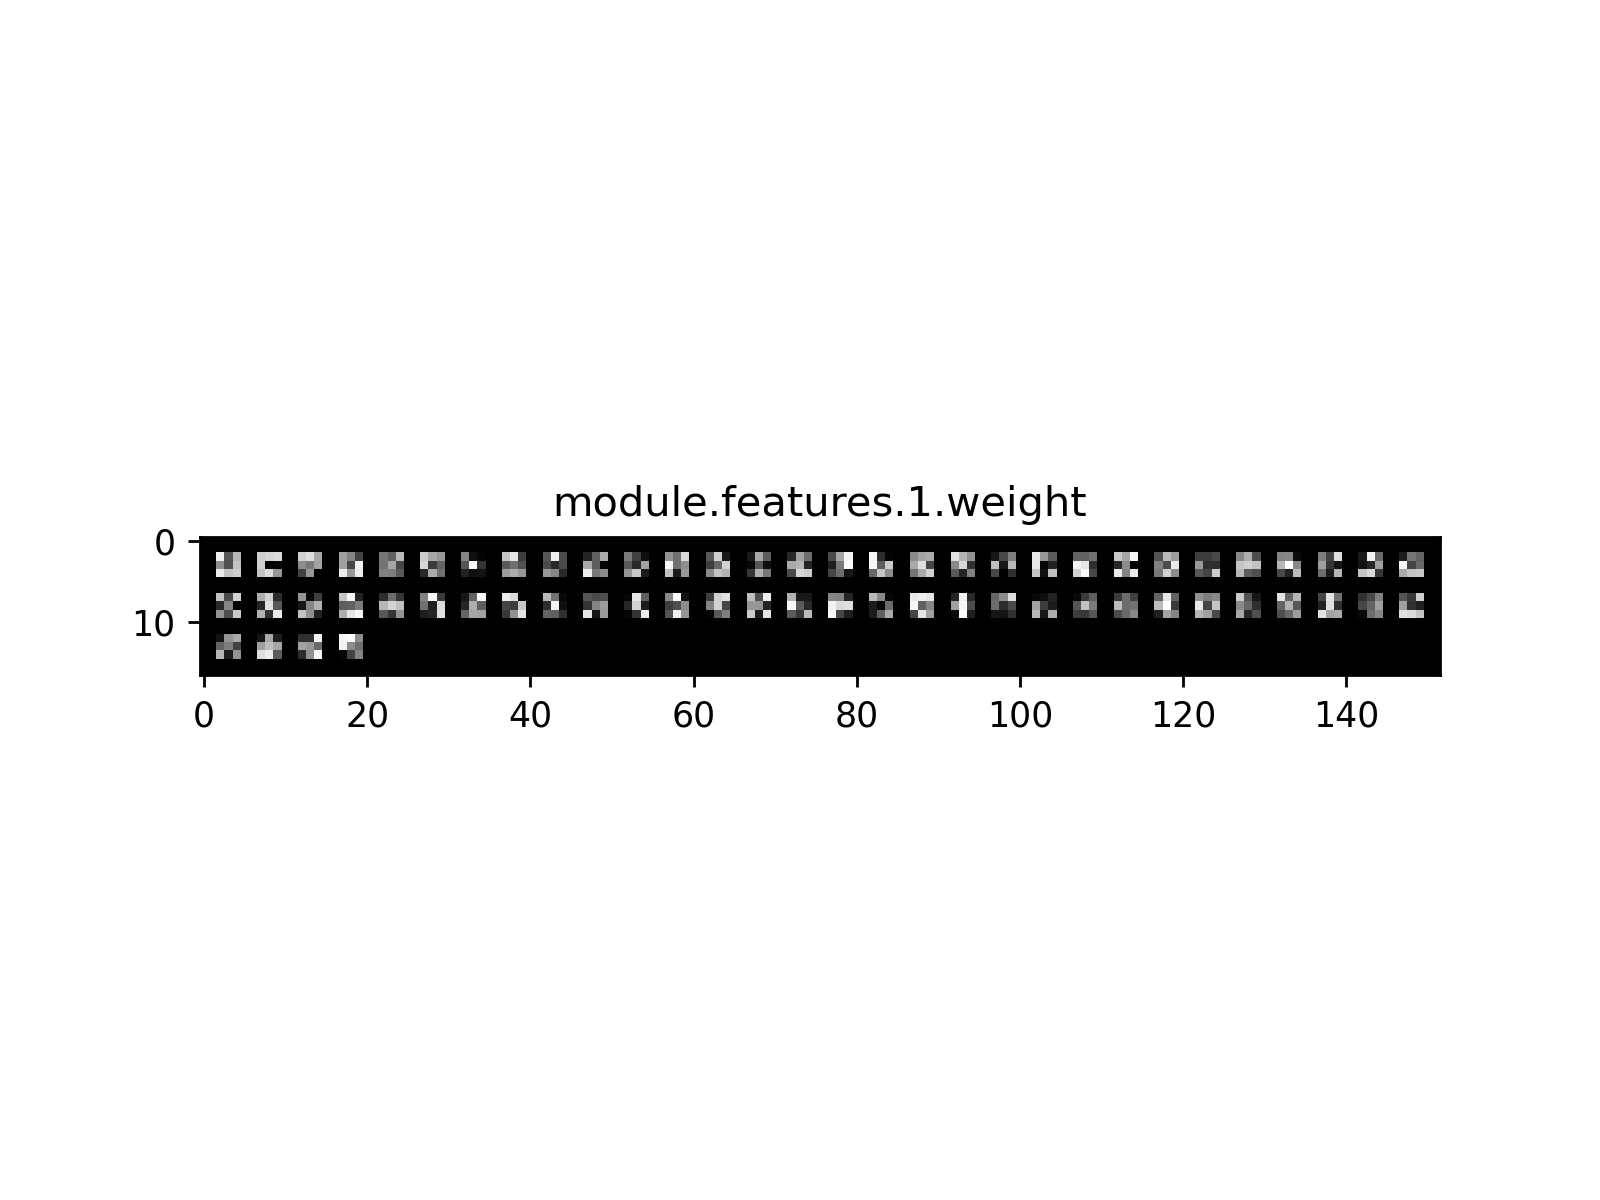

<IPython.core.display.Javascript object>


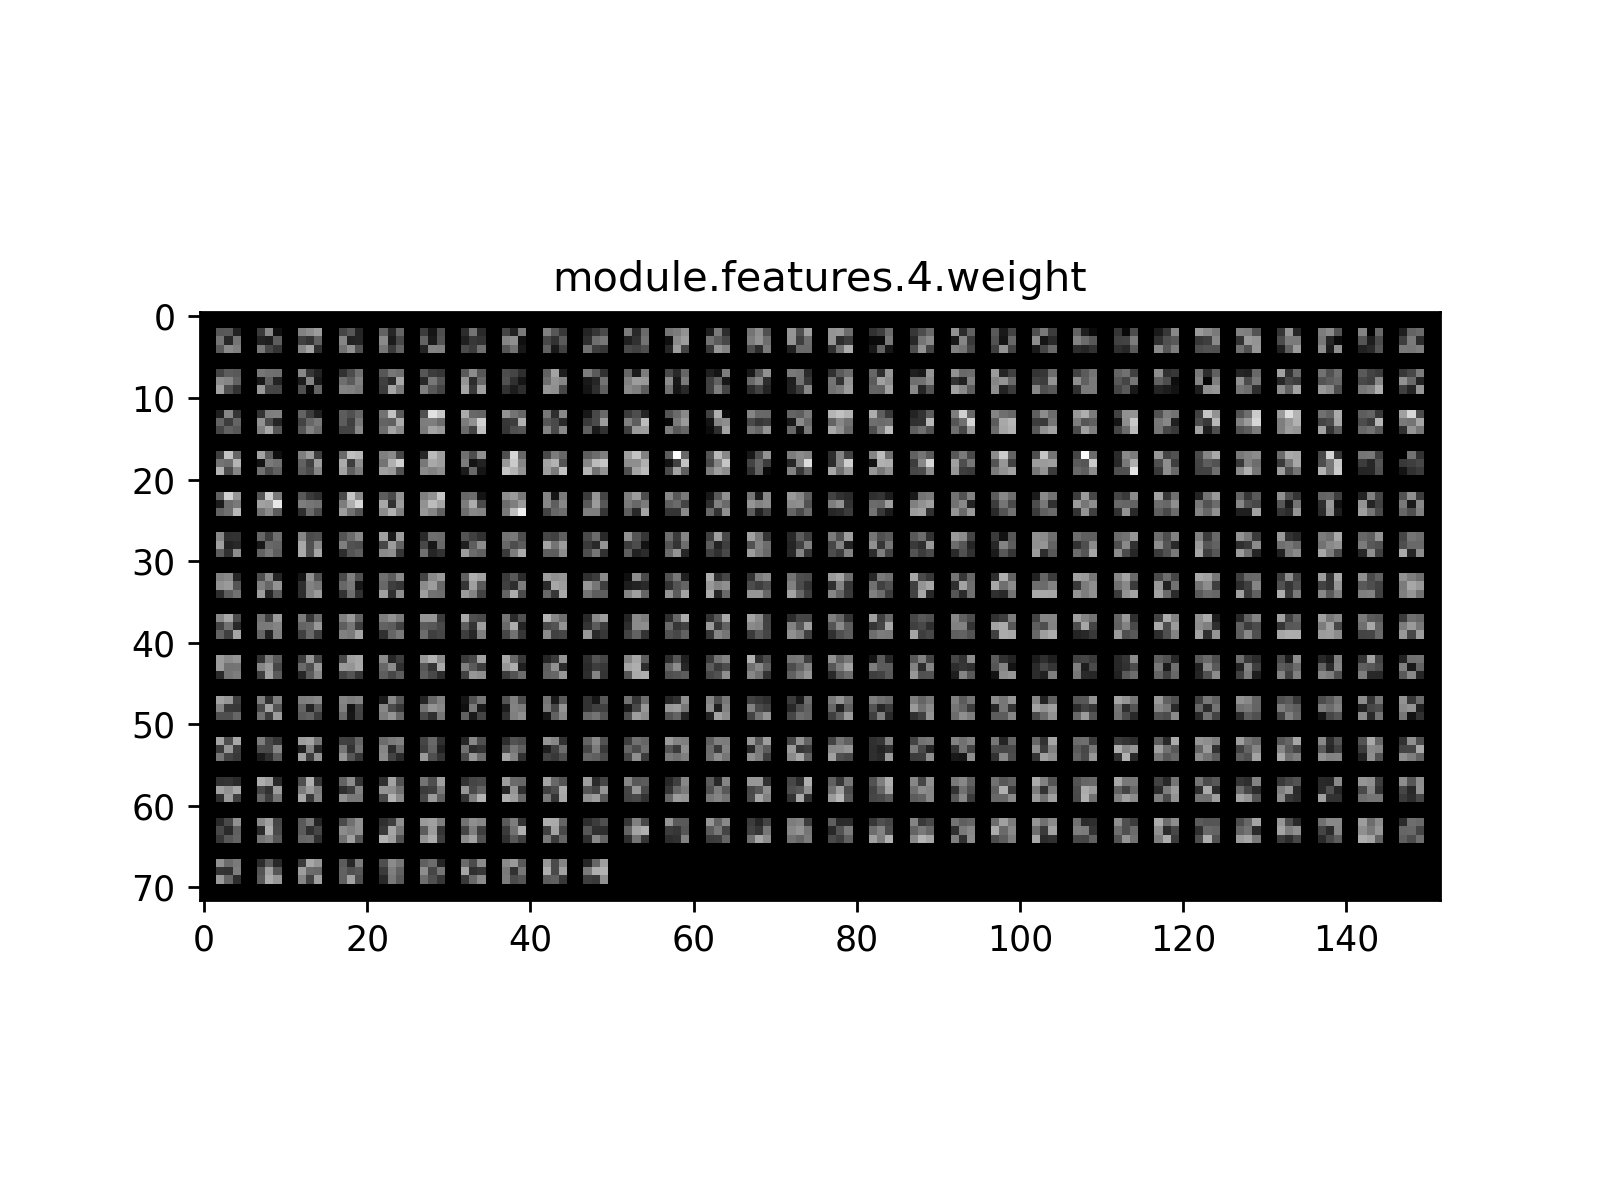

<IPython.core.display.Javascript object>


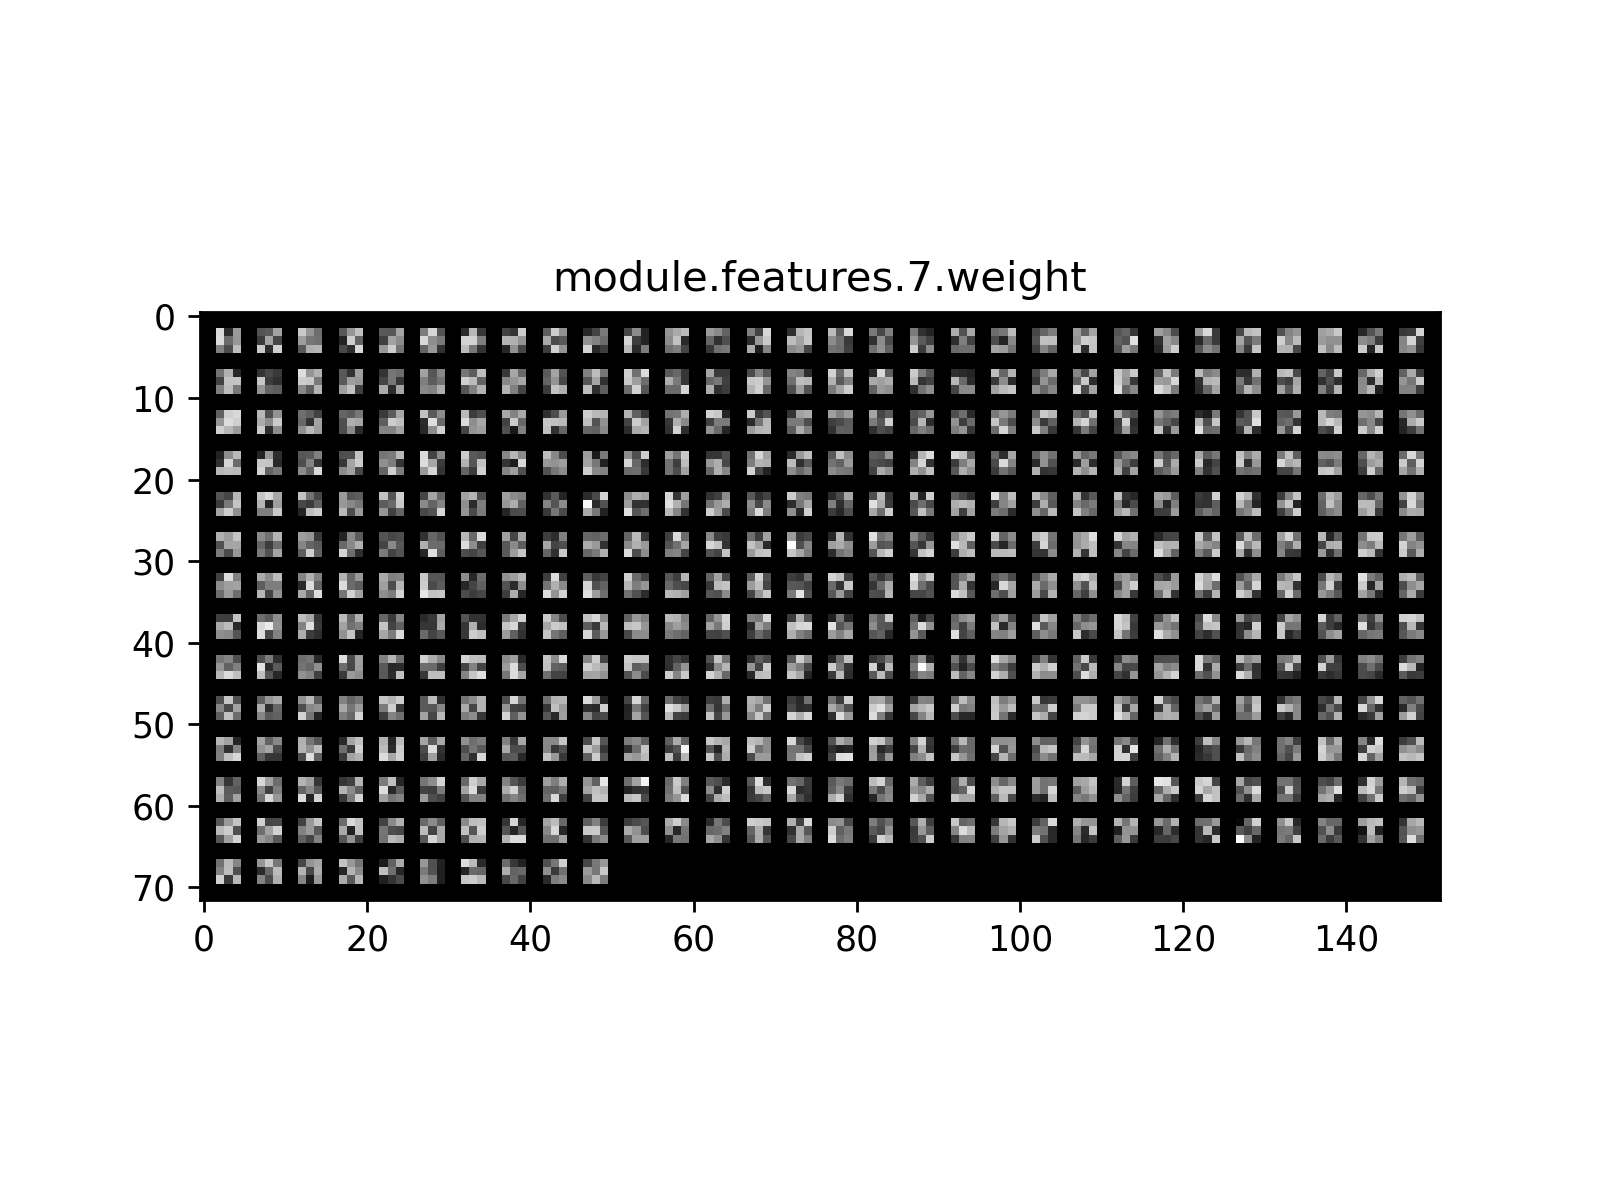

<IPython.core.display.Javascript object>


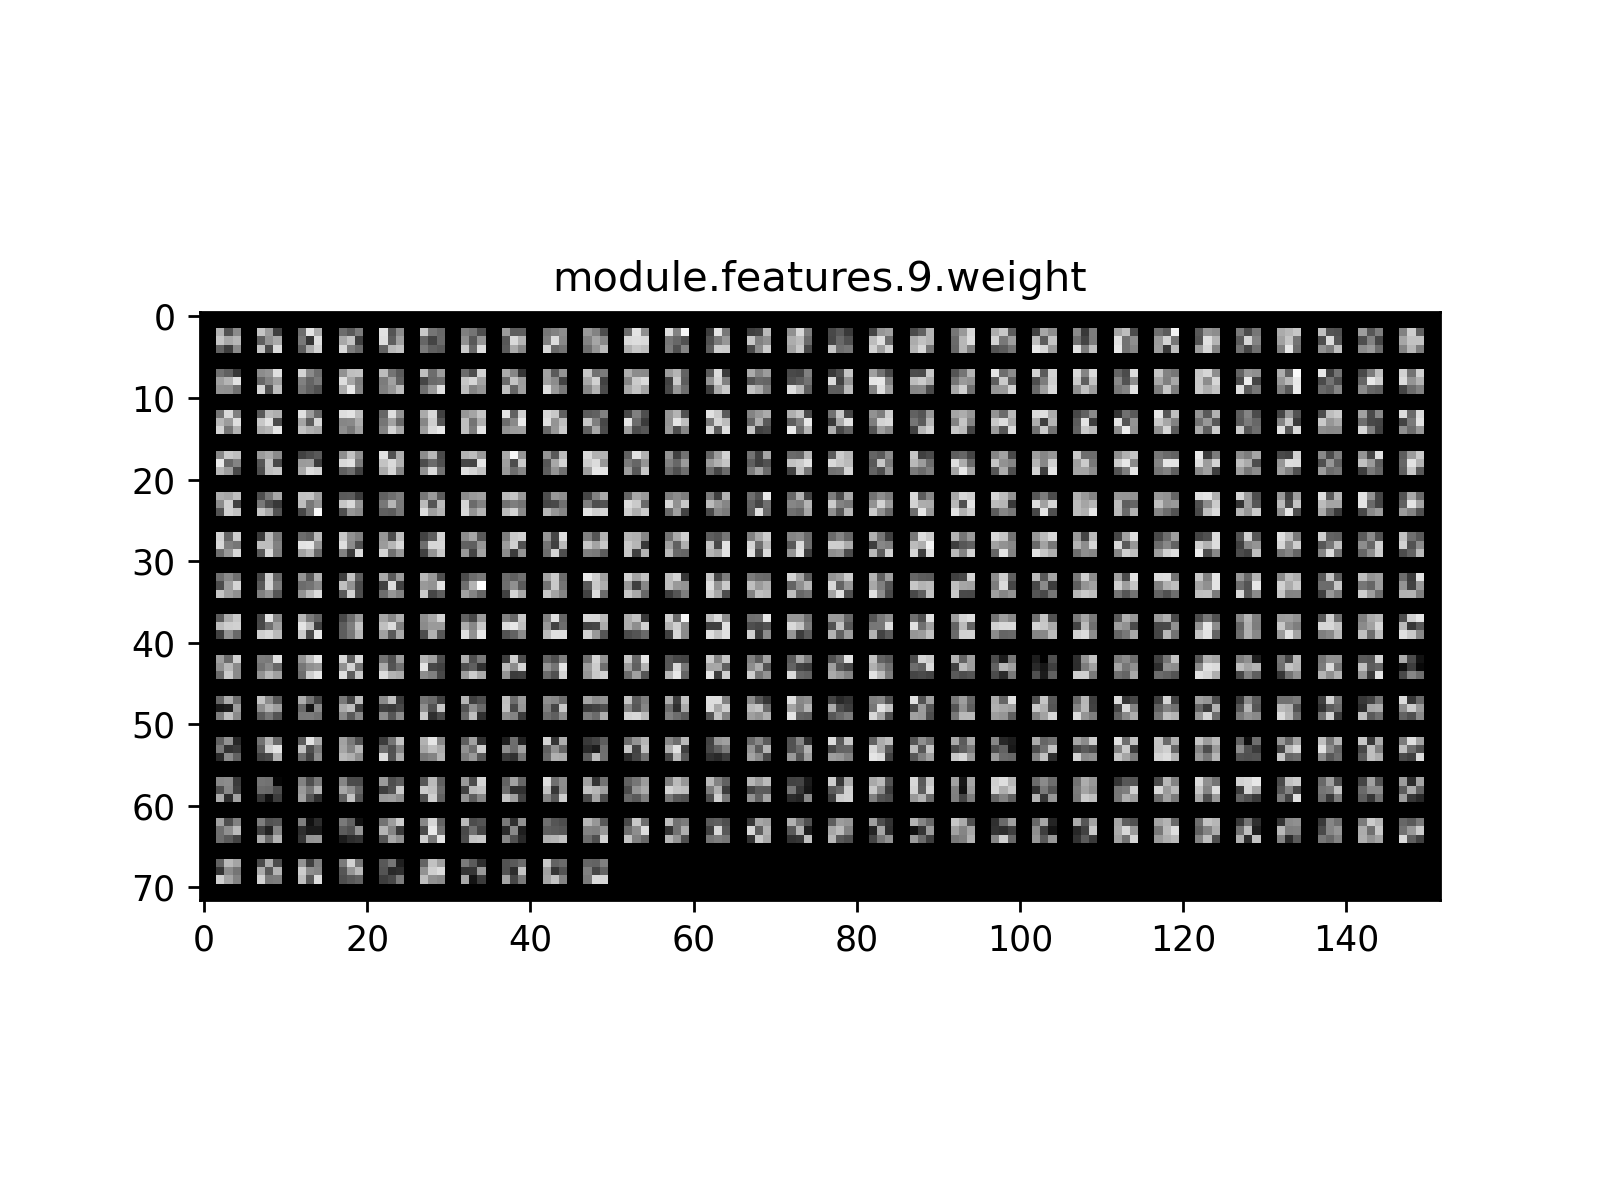

<IPython.core.display.Javascript object>


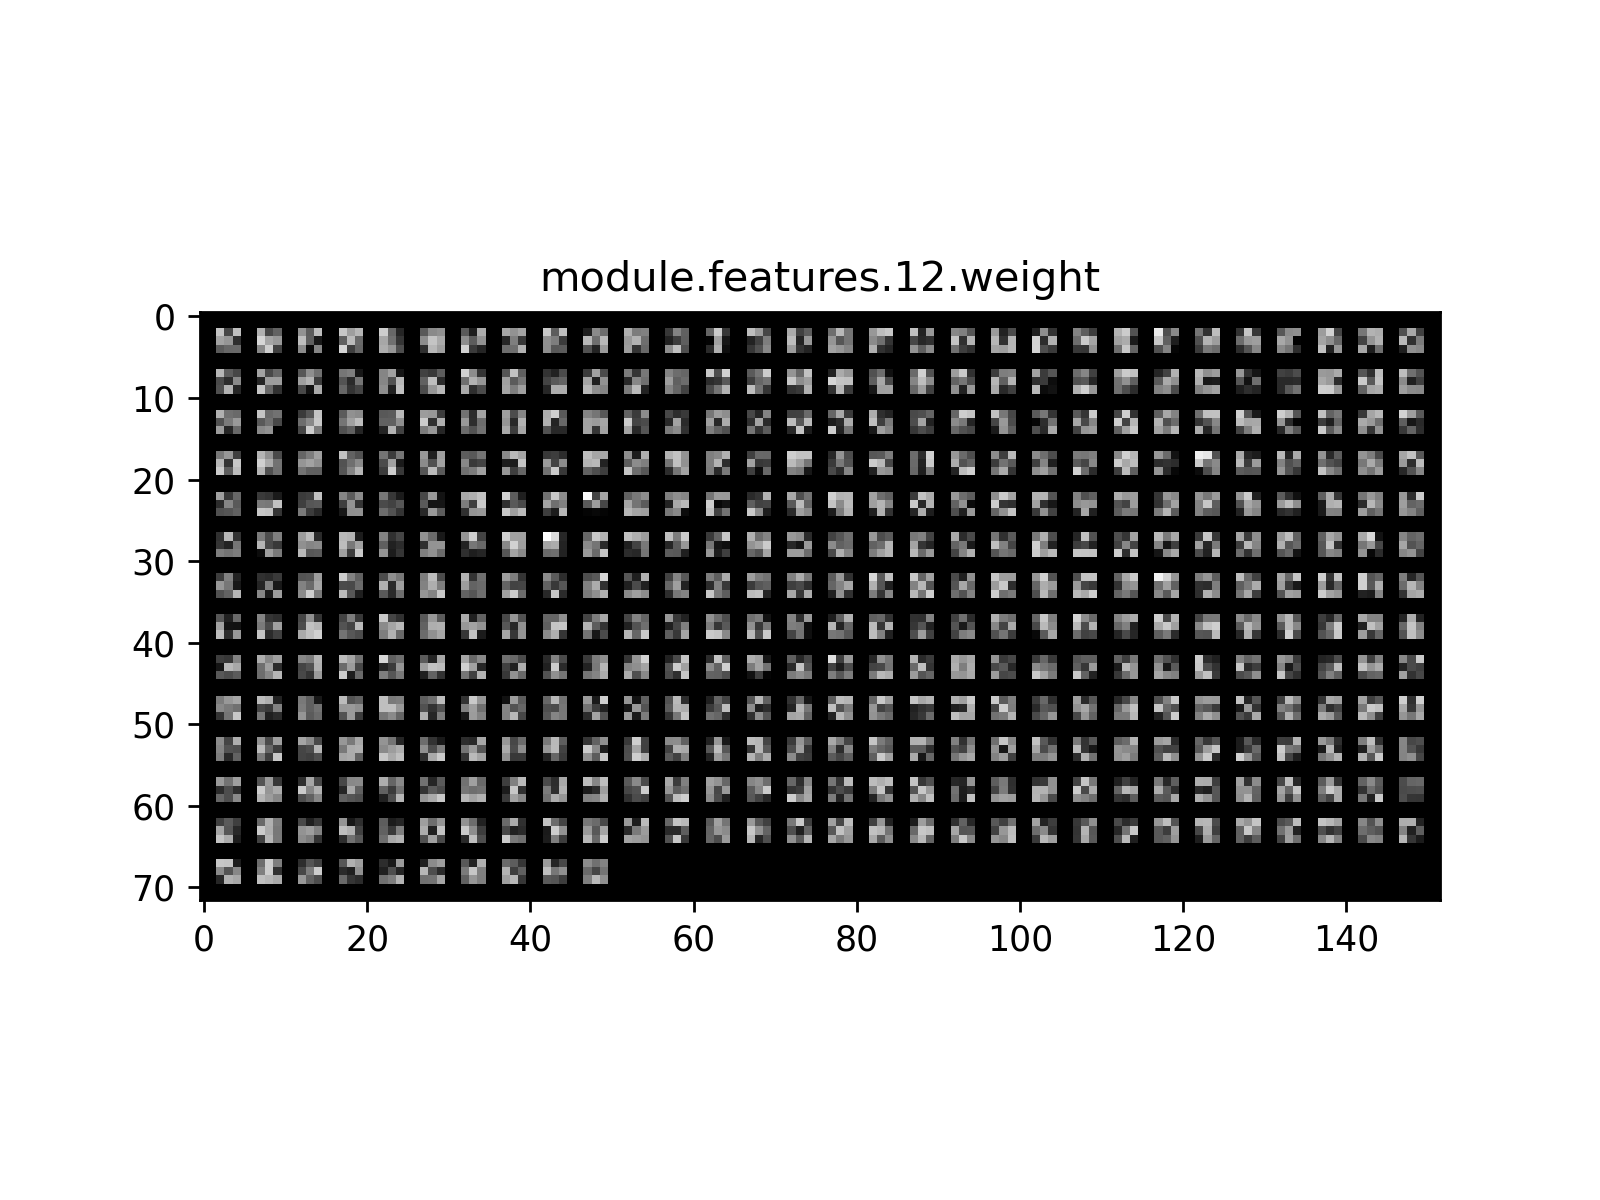

<IPython.core.display.Javascript object>


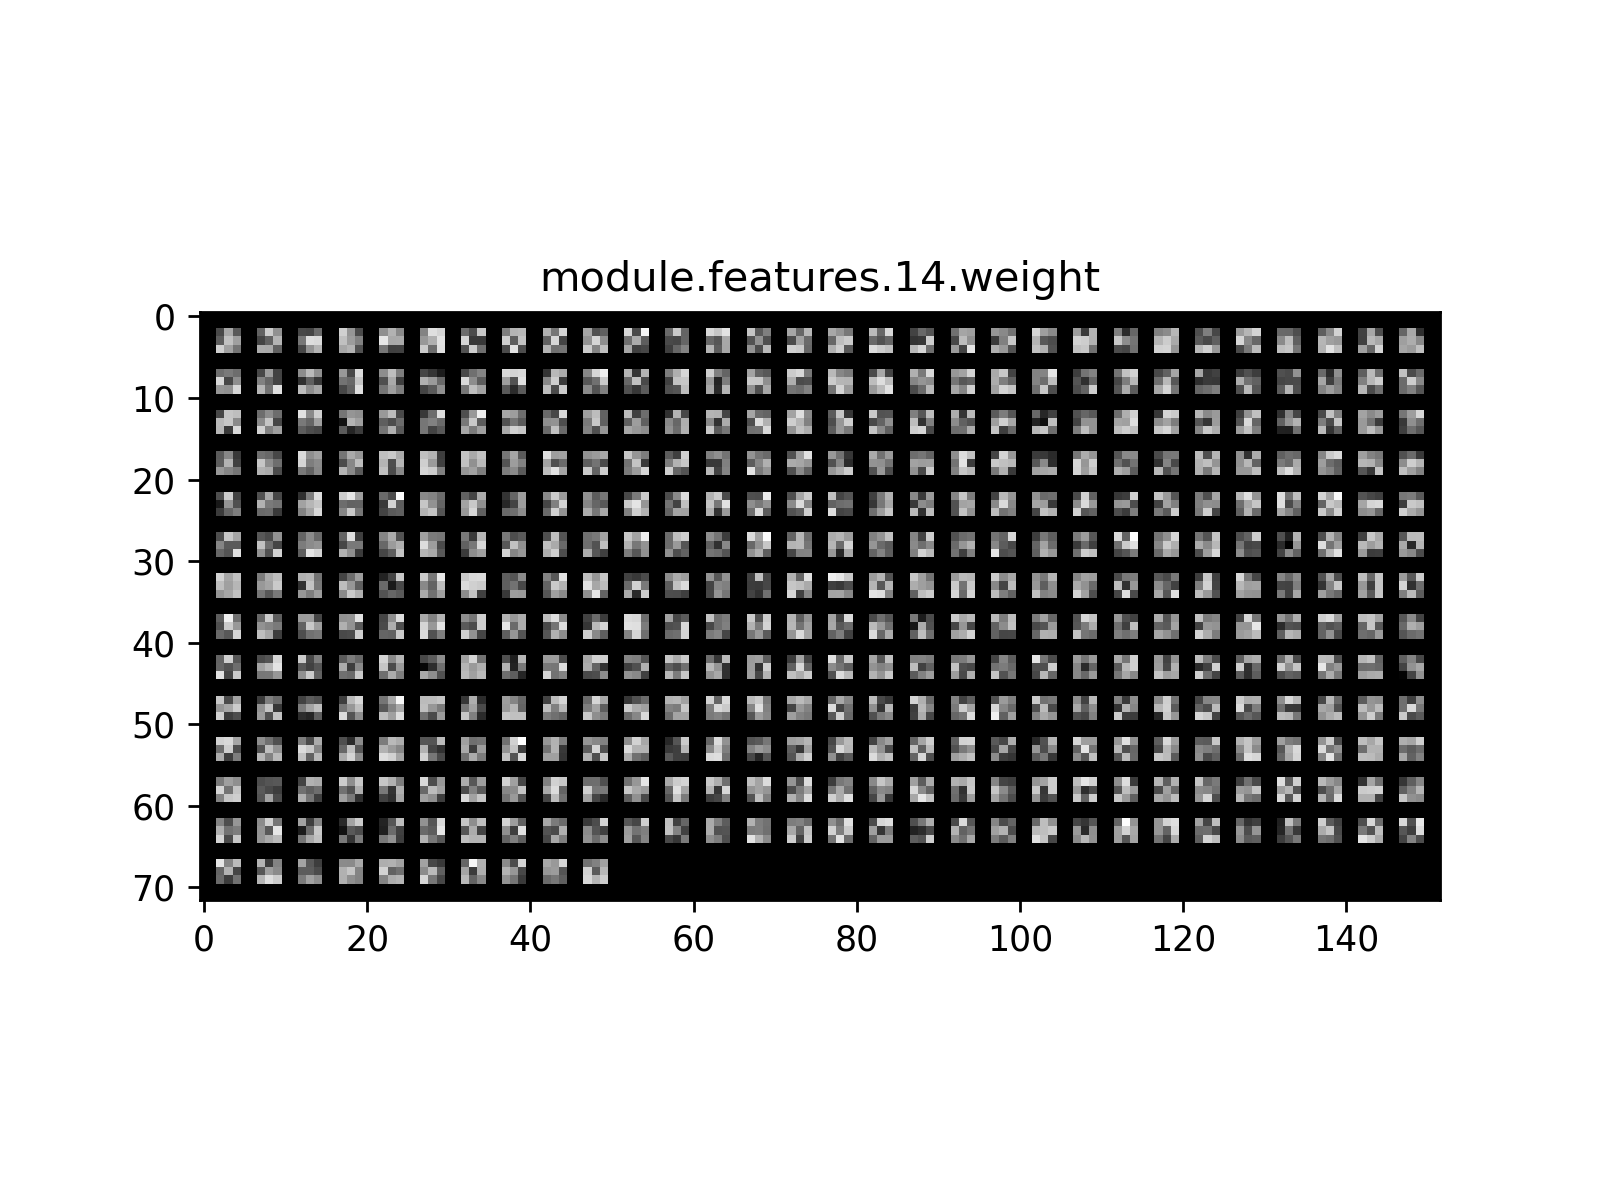

<IPython.core.display.Javascript object>


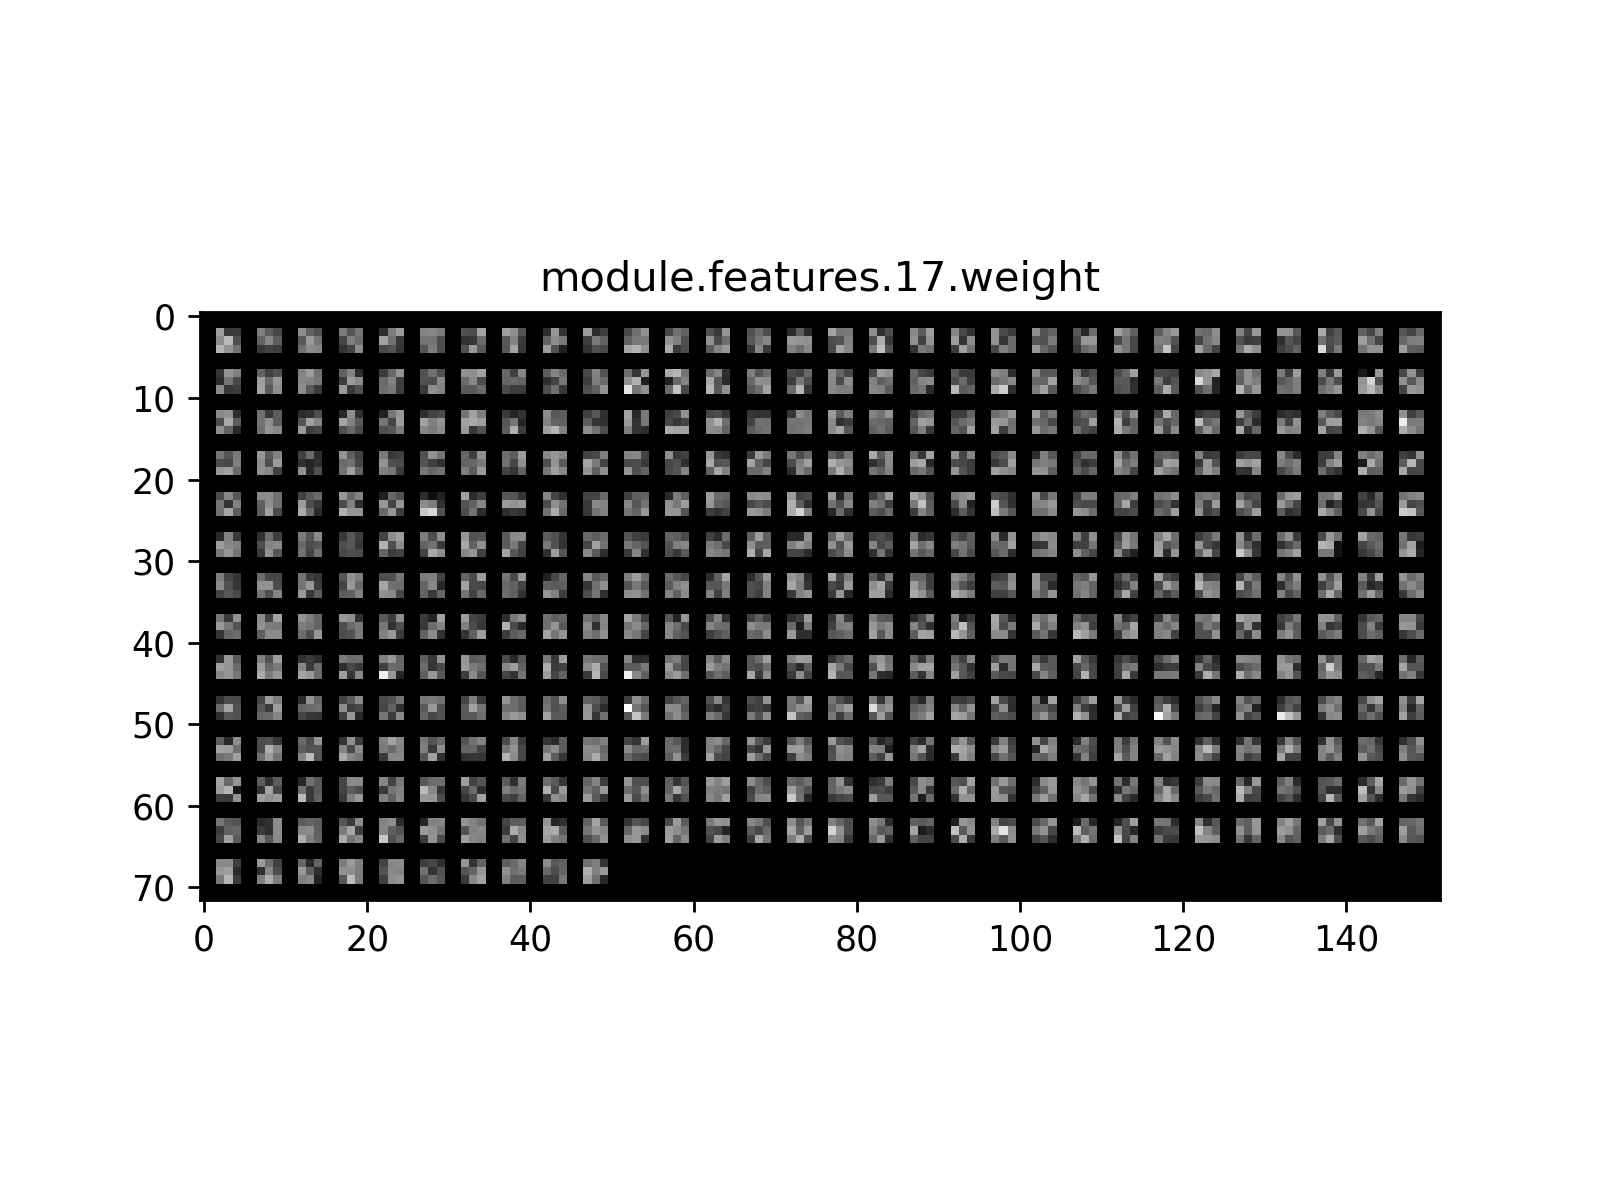

<IPython.core.display.Javascript object>


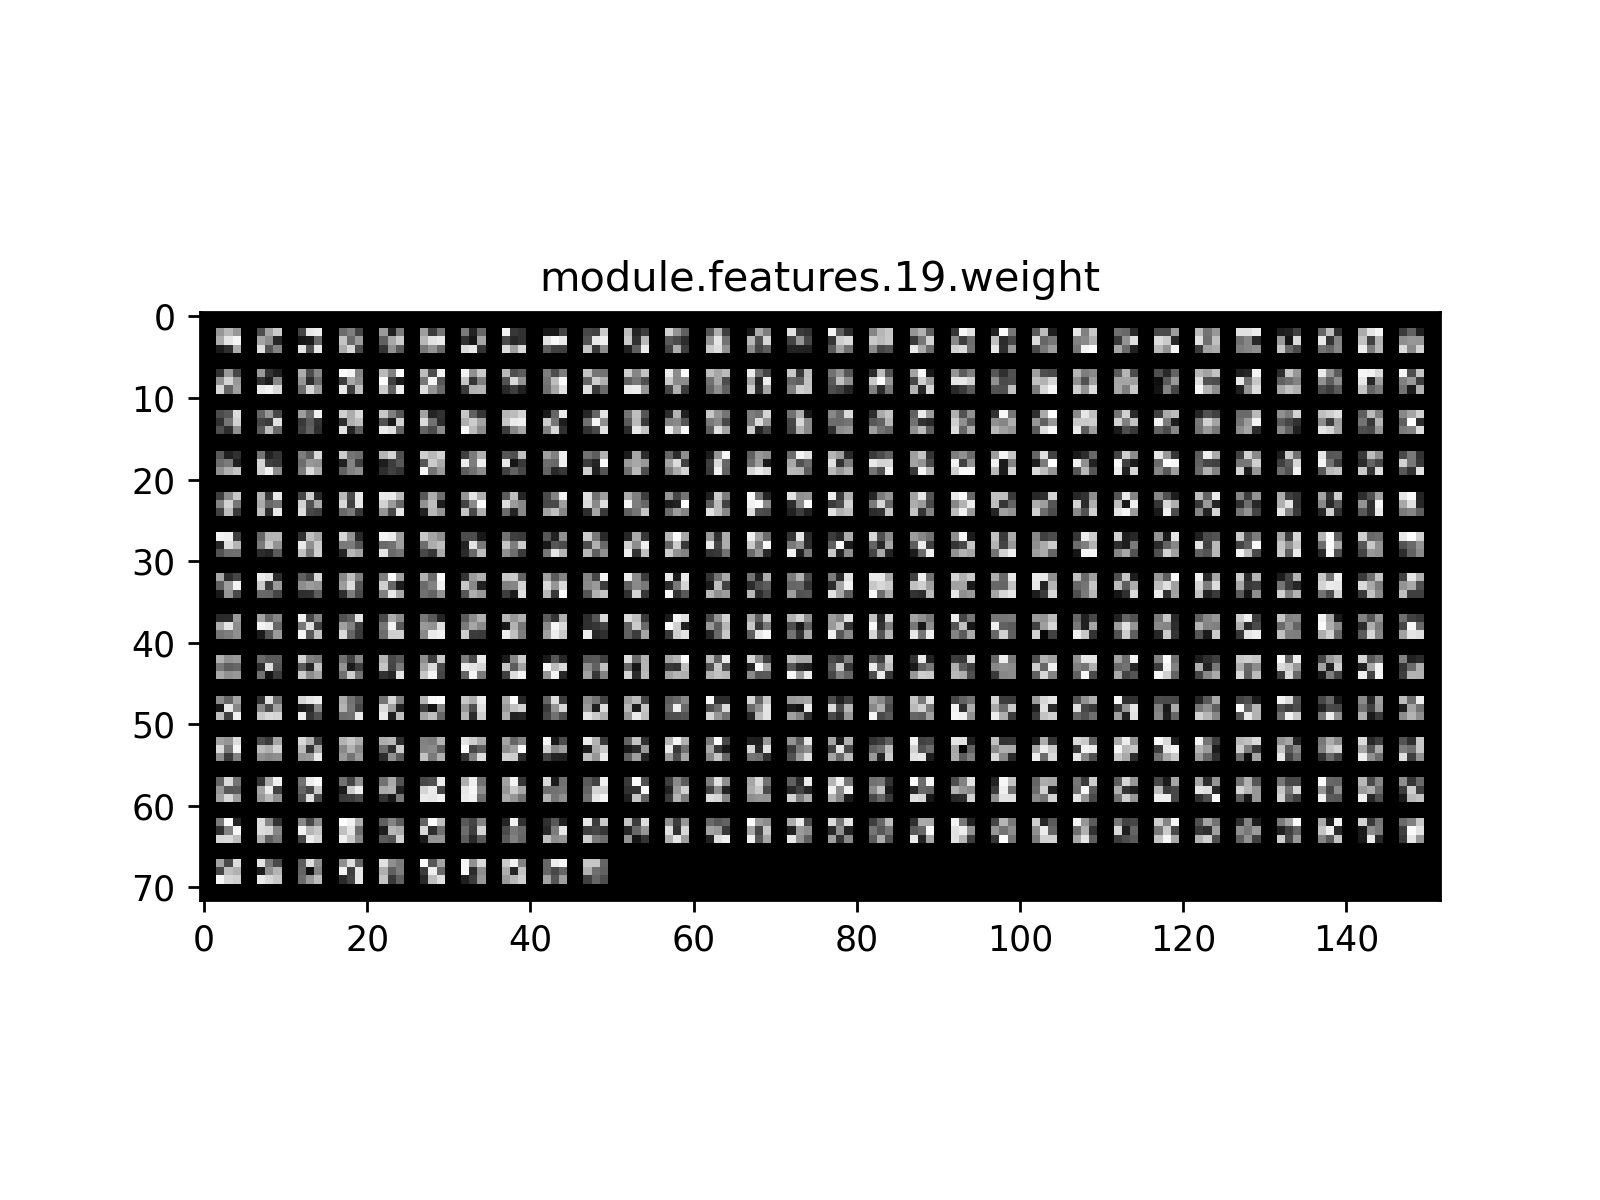

In [162]:
%matplotlib notebook
for k in state:
    if len(state[k].shape) == 4:
        plt.figure()
        plt.title(k)
        plt.imshow(torchvision.utils.make_grid(state[k].flatten(0, 1)[:400, None], nrow=30, normalize=True).permute(1, 2, 0).cpu())

In [222]:
nd

tensor(1.4630)